<a href="https://colab.research.google.com/github/yeonyoo/Final-Team2/blob/main/Final_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/combined_dataset.csv')

In [2]:
#한글 글씨 폰트 설치
%%capture
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'

# 표에서 ('-') 마이너스 표시
plt.rcParams['axes.unicode_minus'] = False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11446 entries, 0 to 11445
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            11446 non-null  int64  
 1   listing_url                                   11446 non-null  object 
 2   scrape_id                                     11446 non-null  int64  
 3   last_scraped                                  11446 non-null  object 
 4   source                                        11446 non-null  object 
 5   name                                          11446 non-null  object 
 6   description                                   9276 non-null   object 
 7   neighborhood_overview                         5663 non-null   object 
 8   picture_url                                   11446 non-null  object 
 9   host_id                                       11446 non-null 

In [4]:
df.shape

(11446, 75)

In [5]:
df['host_response_rate'].describe()

,host_response_rate
count,10000
unique,62
top,100%
freq,7899


In [6]:
df['host_acceptance_rate'].describe()

,host_acceptance_rate
count,10641
unique,95
top,100%
freq,5668


In [7]:
df['host_response_time'].describe()

,host_response_time
count,10000
unique,4
top,within an hour
freq,8461


#전처리

In [8]:
#전처리
df_clean = df.copy()


#리뷰 개수 별 그룹 세분화
bins = [-1, 0, 4, 100, 200, 300, 400, 500, 600, float("inf")]
labels = ["zero", "under_5", "review_100", "review_200", "review_300",
          "review_400", "review_500", "review_600", "review_700+"]
df_clean["host_review_grade"] = pd.cut(df_clean["number_of_reviews"],
                                       bins=bins, labels=labels)



# host_response_rate host_acceptance_rate  숫자 변환
df_clean['host_response_rate'] = df_clean['host_response_rate'].replace('%','', regex=True).astype(float)
df_clean['host_acceptance_rate'] = df_clean['host_acceptance_rate'].replace('%','', regex=True).astype(float)



#호스팅 기간 hosting_days, hosting_years계산: last_scraped - host_since
#objecct -> datetime 날짜 형식으로 변환
df_clean['last_scraped'] = pd.to_datetime(df_clean['last_scraped'])
df_clean['host_since'] = pd.to_datetime(df_clean['host_since'])
df_clean['hosting_days'] = (df_clean['last_scraped'] - df_clean['host_since']).dt.days
df_clean['hosting_years'] = df_clean['hosting_days'] / 365.25



#호스팅 시작하고 첫 리뷰 받기까지의 기간 til_first_review_days, til_first_review_years : host_since  - first_review
df_clean['first_review'] = pd.to_datetime(df_clean['first_review'])
df_clean['last_review'] = pd.to_datetime(df_clean['last_review'])
df_clean['til_first_review_days'] = (df_clean['first_review']-df_clean['host_since']).dt.days
df_clean['til_first_review_years'] = df_clean['til_first_review_days'] / 365.25



#til_first_review_days 가 음수인 총 33개에 대하여 각 그룹별 '중앙값'으로 대치
# 1) 그룹별 중앙값(음수 제외하고 계산)
group_medians = (
    df_clean[df_clean["til_first_review_days"] >= 0]
    .groupby("host_review_grade")["til_first_review_days"]
    .median())
# 2) 음수값을 그룹별 중앙값으로 대치
def replace_with_group_median(row):
    if row["til_first_review_days"] < 0:
        return group_medians[row["host_review_grade"]]
    else:
        return row["til_first_review_days"]
df_clean["til_first_review_days"] = df_clean.apply(replace_with_group_median, axis=1)
# 3) til_first_review_years도 다시 업데이트
df_clean["til_first_review_years"] = df_clean["til_first_review_days"] / 365.25



#host_response_time 결측치 Unknown 으로 변경
df_clean['host_response_time'] = df_clean['host_response_time'].fillna('Unknown')



# 응답시간 점수화 (빠를수록 높은 점수)
resp_time_score_map = {
    "within an hour": 4,
    "within a few hours": 3,
    "within a day": 2,
    "a few days or more": 1,
    "Unknown": 0}
df_clean["host_response_time_score"] = df_clean["host_response_time"].map(resp_time_score_map)

/tmp/ipython-input-2634914392.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("host_review_grade")["til_first_review_days"]


In [9]:
df_clean.shape

(11446, 81)

In [10]:
df['host_response_rate'].describe()

,host_response_rate
count,10000
unique,62
top,100%
freq,7899


In [11]:
df['host_acceptance_rate'].describe()

,host_acceptance_rate
count,10641
unique,95
top,100%
freq,5668


In [12]:
df['host_response_time'].describe()

,host_response_time
count,10000
unique,4
top,within an hour
freq,8461


#시각화
(1) 응답률 vs 리뷰수  
(2) 응답시간(문자열) vs 리뷰수  — 결측치는 'Unknown'으로 표시  
(3) 수락률 vs 리뷰수

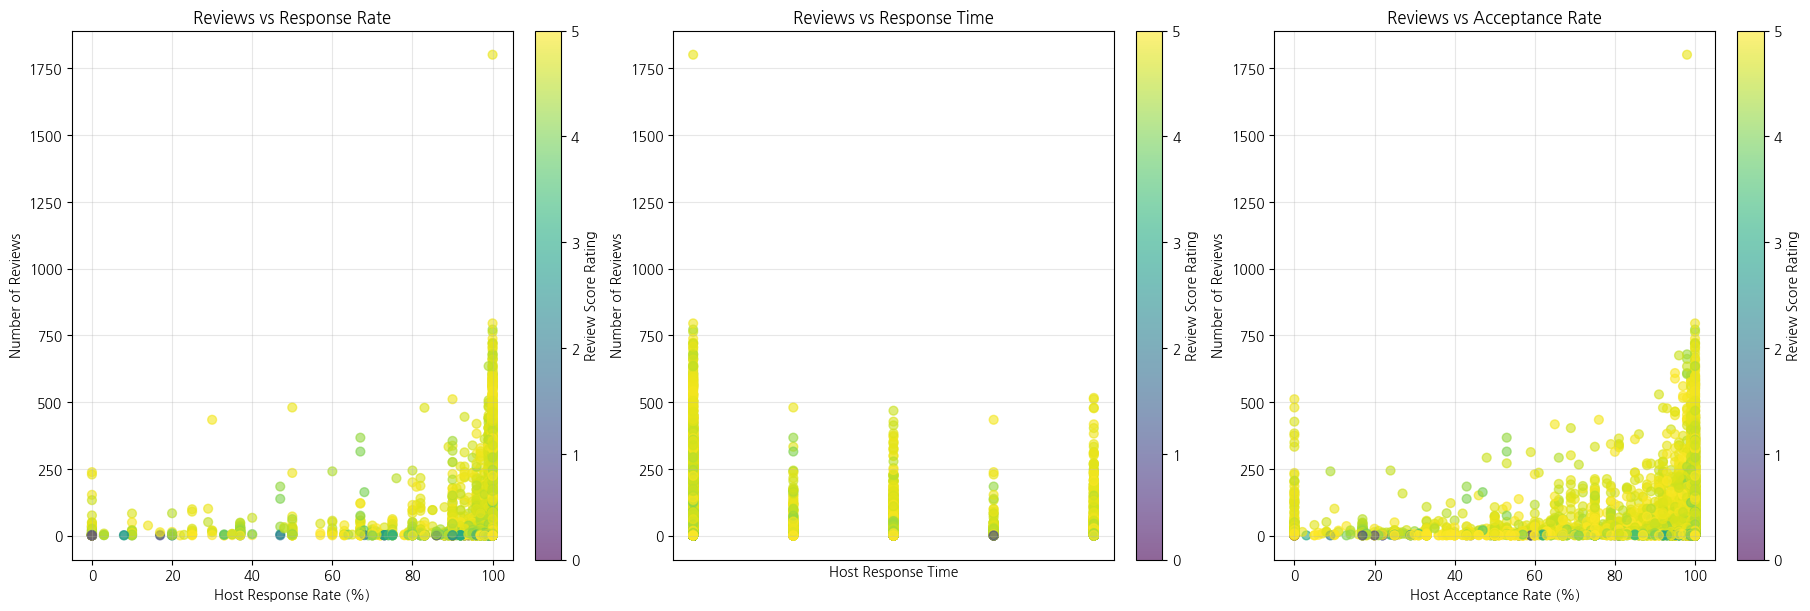

In [14]:
# === 산점도 3종 ===

import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# 공통 설정 - 산점도 색깔을 리뷰 평점(review_scores_rating) 값으로 입히고, 색상바(colorbar) 레이블도 자동으로 추가
cvals = df_clean['review_scores_rating'] if 'review_scores_rating' in df_clean.columns else None
cbar_label = 'Review Score Rating' if cvals is not None else None

# (1) 응답률 vs 리뷰수
sc0 = axes[0].scatter(
    df_clean['host_response_rate'],
    df_clean['number_of_reviews'],
    c=cvals, cmap='viridis', alpha=0.6, s=40
)
if cvals is not None:
    fig.colorbar(sc0, ax=axes[0], label=cbar_label)
axes[0].set_xlabel('Host Response Rate (%)')
axes[0].set_ylabel('Number of Reviews')
axes[0].set_title('Reviews vs Response Rate')
axes[0].grid(True, alpha=0.3)

# (2) 응답시간(문자열) vs 리뷰수  — 결측치는 'Unknown'으로 표시
sc1 = axes[1].scatter(
     df_clean['host_response_time'],
    df_clean['number_of_reviews'],
    c=cvals, cmap='viridis', alpha=0.6, s=40
)
if cvals is not None:
    fig.colorbar(sc1, ax=axes[1], label=cbar_label)
# 카테고리 순서 지정(데이터에 있는 것만 표시)
ordered = ['within an hour','within a few hours','within a day','a few days or more','Unknown']
present = [lab for lab in ordered if lab in set(df_clean)]
axes[1].set_xticks(range(len(present)))
axes[1].set_xticklabels(present, rotation=15)
axes[1].set_xlabel('Host Response Time')
axes[1].set_ylabel('Number of Reviews')
axes[1].set_title('Reviews vs Response Time')
axes[1].grid(True, alpha=0.3)

# (3) 수락률 vs 리뷰수
sc2 = axes[2].scatter(
    df_clean['host_acceptance_rate'],
    df_clean['number_of_reviews'],
    c=cvals, cmap='viridis', alpha=0.6, s=40
)
if cvals is not None:
    fig.colorbar(sc2, ax=axes[2], label=cbar_label)
axes[2].set_xlabel('Host Acceptance Rate (%)')
axes[2].set_ylabel('Number of Reviews')
axes[2].set_title('Reviews vs Acceptance Rate')
axes[2].grid(True, alpha=0.3)

plt.show()



In [15]:
df_clean['number_of_reviews'].describe()

,number_of_reviews
count,11446.000000
mean,59.958850
std,99.617144
min,0.000000
25%,3.000000
50%,18.000000
75%,70.000000
max,1801.000000


###전처리) 극단치 대치 조언 구하기

In [16]:
# 극단치 대치 - number_of_reviews가 1801인 극단치를 그 다음 작은 수로 대치
# 최대값과 두 번째 최대값 찾기
review_max = df_clean['number_of_reviews'].max()
second_max = df_clean.loc[df_clean['number_of_reviews'] < review_max, 'number_of_reviews'].max()

# 최대값을 두 번째 최대값으로 대체
df_clean.loc[df_clean['number_of_reviews'] == review_max, 'number_of_reviews'] = second_max

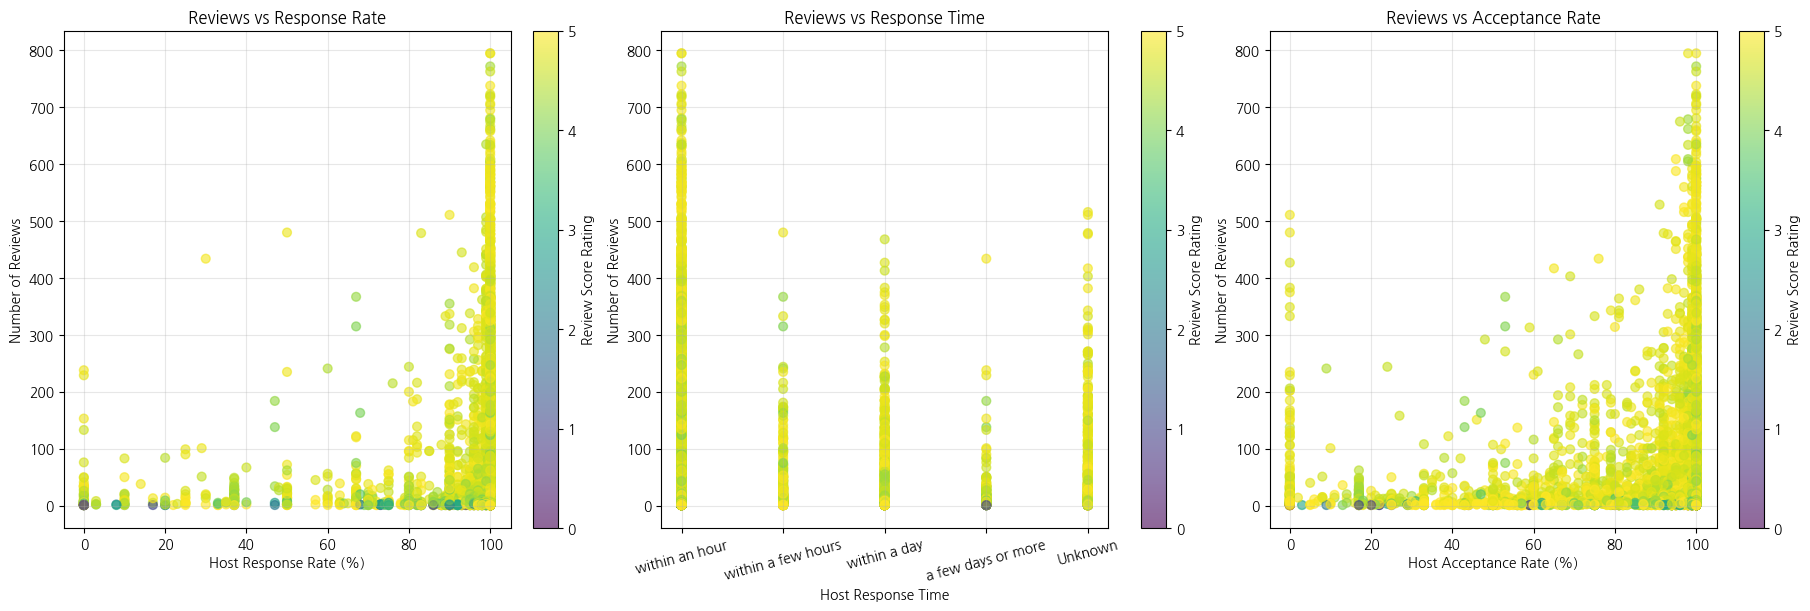

In [17]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# 공통 설정 - 산점도 색깔을 리뷰 평점(review_scores_rating) 값으로 입히고, 색상바(colorbar) 레이블도 자동으로 추가
cvals = df_clean['review_scores_rating'] if 'review_scores_rating' in df_clean.columns else None
cbar_label = 'Review Score Rating' if cvals is not None else None

# (1) 응답률 vs 리뷰수
sc0 = axes[0].scatter(
    df_clean['host_response_rate'],
    df_clean['number_of_reviews'],
    c=cvals, cmap='viridis', alpha=0.6, s=40
)
if cvals is not None:
    fig.colorbar(sc0, ax=axes[0], label=cbar_label)
axes[0].set_xlabel('Host Response Rate (%)')
axes[0].set_ylabel('Number of Reviews')
axes[0].set_title('Reviews vs Response Rate')
axes[0].grid(True, alpha=0.3)

# (2) 응답시간(문자열) vs 리뷰수
sc1 = axes[1].scatter(
     df_clean['host_response_time'],
    df_clean['number_of_reviews'],
    c=cvals, cmap='viridis', alpha=0.6, s=40
)
if cvals is not None:
    fig.colorbar(sc1, ax=axes[1], label=cbar_label)
# 카테고리 순서 지정(데이터에 있는 것만 표시)
ordered = ['within an hour','within a few hours','within a day','a few days or more','Unknown']
present = [lab for lab in ordered if lab in set(df_clean['host_response_time'])]
axes[1].set_xticks(range(len(present)))
axes[1].set_xticklabels(present, rotation=15)
axes[1].set_xlabel('Host Response Time')
axes[1].set_ylabel('Number of Reviews')
axes[1].set_title('Reviews vs Response Time')
axes[1].grid(True, alpha=0.3)

# (3) 수락률 vs 리뷰수
sc2 = axes[2].scatter(
    df_clean['host_acceptance_rate'],
    df_clean['number_of_reviews'],
    c=cvals, cmap='viridis', alpha=0.6, s=40
)
if cvals is not None:
    fig.colorbar(sc2, ax=axes[2], label=cbar_label)
axes[2].set_xlabel('Host Acceptance Rate (%)')
axes[2].set_ylabel('Number of Reviews')
axes[2].set_title('Reviews vs Acceptance Rate')
axes[2].grid(True, alpha=0.3)

plt.show()

###차트 분석
**Reviews vs Response Rate**
응답률이 높을수록(특히 100% 근처) 리뷰 수가 많은 호스트가 집중되어 있음.

**Reviews vs Response Time**  
응답시간이 빠른 그룹(within an hour, within a few hours) 에서 리뷰 수가 많고 응답이 느린 그룹(a few days or more)은 거의 리뷰 수가 적음.
빠른 응답이 더 많은 리뷰 확보와 연결되는 경향을 시각적으로 확인 가능.

**Reviews vs Acceptance Rate**
수락률이 높을 수록 리뷰 수가 증가하는 패턴을 보임. 다만 Host Acceptance Rate가 0인데 리뷰 수가 있는 값들에 대해서는 처리가 필요해보임

#검증 전 각 필드별 결측값 확인
(host_response_time은 이미 앞에서 처리 함_범주형 Unknown으로)

In [18]:
df_clean[['host_response_rate','host_acceptance_rate']].isna().sum()

,0
host_response_rate,1446
host_acceptance_rate,805


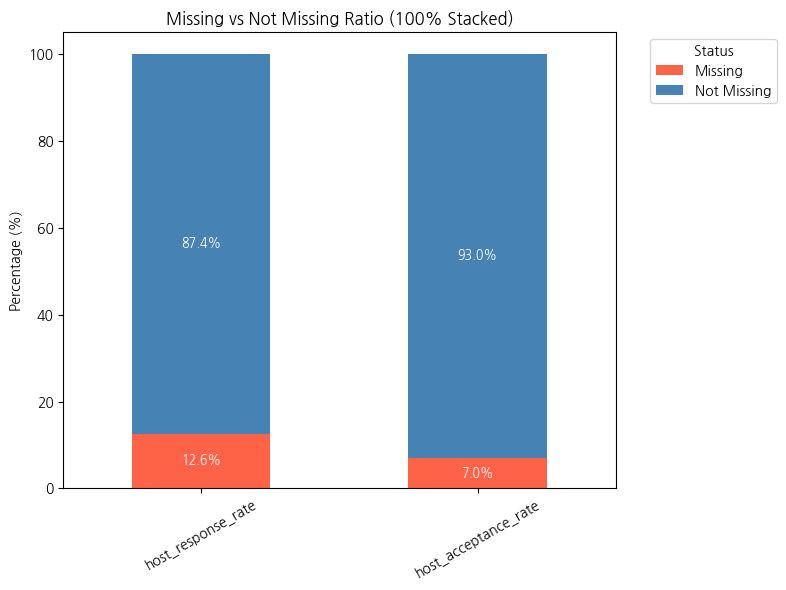

In [19]:
import matplotlib.pyplot as plt

# 확인할 컬럼들
cols = ['host_response_rate', 'host_acceptance_rate']

# 결측/비결측 개수 계산
missing = df_clean[cols].isnull().sum()
not_missing = df_clean[cols].notnull().sum()

df_missing = pd.DataFrame({
    'Missing': missing,
    'Not Missing': not_missing
}, index=cols)

# 비율 변환 (%)
df_ratio = df_missing.div(df_missing.sum(axis=1), axis=0) * 100

# 플롯
ax = df_ratio.plot(
    kind='bar',
    stacked=True,
    figsize=(8,6),
    color=['tomato','steelblue']
)

plt.title("Missing vs Not Missing Ratio (100% Stacked)")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=30)
plt.legend(title="Status", bbox_to_anchor=(1.05,1), loc='upper left')

# --- 수치 라벨 표시 ---
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:  # 비율이 0이 아닐 때만 표시
        ax.text(x + width/2, y + height/2,
                f"{height:.1f}%",
                ha='center', va='center', fontsize=9, color='white', fontweight='bold')

plt.tight_layout()
plt.show()


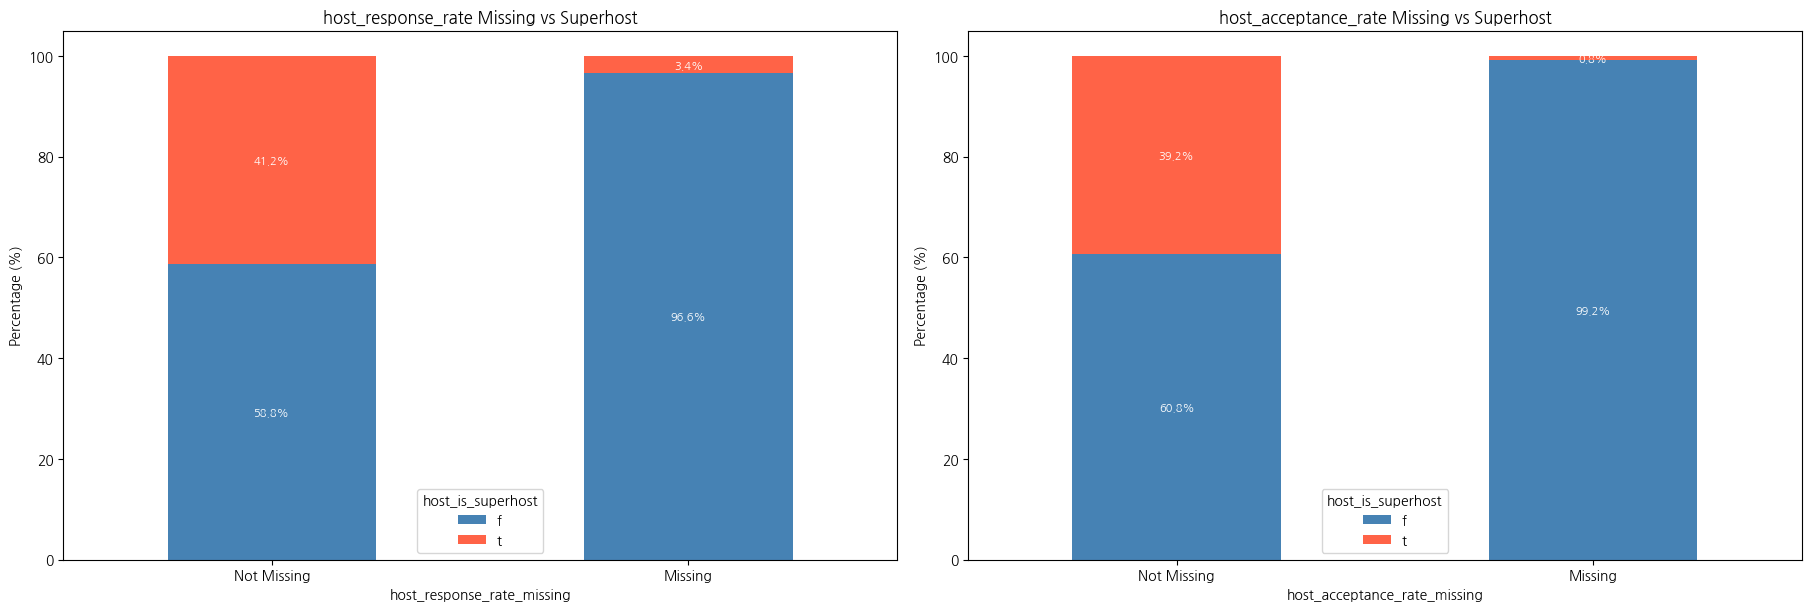

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

cols = ['host_response_rate', 'host_acceptance_rate']

fig, axes = plt.subplots(1, 2, figsize=(18,6), constrained_layout=True)

for i, col in enumerate(cols):
    # 결측 여부 플래그
    df_clean[col + '_missing'] = df_clean[col].isna()

    # 교차표: 결측 여부 vs 슈퍼호스트
    cross = pd.crosstab(df_clean[col + '_missing'], df_clean['host_is_superhost'], normalize='index') * 100

    # 플롯
    cross.plot(kind='bar', stacked=True, ax=axes[i], color=['steelblue','tomato'])
    axes[i].set_title(f"{col} Missing vs Superhost")
    axes[i].set_ylabel("Percentage (%)")
    axes[i].set_xticklabels(['Not Missing','Missing'], rotation=0)

    # 수치 라벨 표시
    for p in axes[i].patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        if height > 0:
            axes[i].text(x + width/2, y + height/2,
                         f"{height:.1f}%",
                         ha='center', va='center', fontsize=8, color='white', fontweight='bold')

plt.show()


In [21]:
cols = ['host_response_rate', 'host_acceptance_rate']

# 현재 전체 행 수
total_n = len(df_clean)

# 두 필드 모두 비결측인 행
df_non_missing = df_clean.dropna(subset=cols)

remain_n = len(df_non_missing)
dropped_n = total_n - remain_n


print(f"전체 행 수: {total_n}")
print(f"제거된 행 수(두 필드 모두 결측 행 수): {dropped_n} ({dropped_n/total_n:.2%})")
print(f"남은 행 수: {remain_n}")

전체 행 수: 11446
제거된 행 수(두 필드 모두 결측 행 수): 1493 (13.04%)
남은 행 수: 9953


결측값이 있는 호스트 중 슈퍼호스트의 비율은 4%안되기때문에 결측값은 누락시킨  ```df_non_missing``` 로 통계 검증 실시

-----------------

##number_of_reviews vs host_response_rate
둘 다 연속형.
상관 관계 분석(피어슨/스피어만) + 회귀분석

In [22]:
from sklearn import datasets

df_non_missing['number_of_reviews'].shape

(9953,)

In [23]:
df_non_missing['host_response_rate'].shape

(9953,)

In [24]:
X = df_non_missing['host_response_rate']
Y = df_non_missing['number_of_reviews']

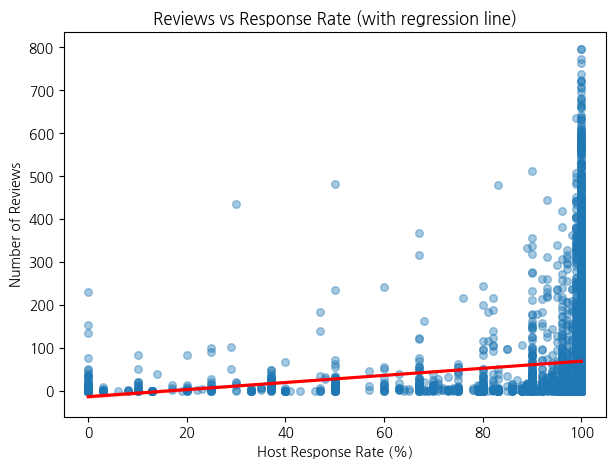

In [25]:
import seaborn as sns

plt.figure(figsize=(7,5))
sns.regplot(x=X, y=Y, scatter_kws={'alpha':0.4, 's':30}, line_kws={'color':'red'})
plt.xlabel("Host Response Rate (%)")
plt.ylabel("Number of Reviews")
plt.title("Reviews vs Response Rate (with regression line)")
plt.show()

In [26]:
import scipy.stats as stats

pearson_r, pearson_p = stats.pearsonr(X, Y)
spearman_r, spearman_p = stats.spearmanr(X, Y)

print(f"Pearson r = {pearson_r:.3f}, p = {pearson_p:.3e}")
print(f"Spearman rho = {spearman_r:.3f}, p = {spearman_p:.3e}")

Pearson r = 0.118, p = 1.884e-32
Spearman rho = 0.213, p = 2.561e-102


In [27]:
import statsmodels.api as sm

X = sm.add_constant(df_non_missing['host_response_rate']) #절편 추가
Y = df_non_missing['number_of_reviews']

model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      number_of_reviews   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     141.7
Date:                Sun, 21 Sep 2025   Prob (F-statistic):           1.88e-32
Time:                        14:20:39   Log-Likelihood:                -60144.
No. Observations:                9953   AIC:                         1.203e+05
Df Residuals:                    9951   BIC:                         1.203e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -14.2145      6.754     -2.105      0.035     -27.453      -0.976
host_response_rate     0.8269      0.069     11.903      0.000       0.691       0.963
==============================================================================
Omnibus:                     5446.223   Durbin-Watson:                   1.139
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            39054.329
Skew:                           2.601   Prob(JB):                         0.00
Kurtosis:                      11.192   Cond. No.                         643.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

참고)
절편을 추가해야 하는 이유  
현실적으로 x=0일 때 y=0일 필요가 없음.  
절편을 포함하면 모델이 데이터에 더 잘 맞게 회귀선을 그릴 수 있음.  
절편 없는 모델은 특정 상황(물리학 법칙 등)에서는 맞을 수 있지만, 대부분의 사회/비즈니스 데이터에는 부적절.

결과 분석
1. p << 0.05 이기때문에 응답률이 높을수록 리뷰가 많을 가능성은 있다.
2. 그러나 그 정도는 약하다.: Pearson 기준으로는 거의 무시 가능한 수준, Spearman은 조금 더 크지만 여전히 '약한 상관'
3. 응답률이 100%인 경우와 같이 특정 구간에 몰려있어서 선형 관계로는 잘 설명이 되지 않음.
4. 응답률(host_response_rate) 하나만으로는 리뷰 수(number_of_reviews) 변동을 1.4%밖에 설명 못 함.

정리)응답률은 통계적으로 리뷰 수와 관련이 있지만, 설명력은 극도로 낮다. 따라서 단독 변수로는 의미 없으며, 응답 시간이나 수락률 등 다른 지표와 함께 보는 것이 필요하다.

##number_of_reviews vs host_response_time
그룹별 평균 차이 검정이 적절
정규성 확인 후 **Kruskal–Wallis(비모수)** 혹은  **ANOVA**

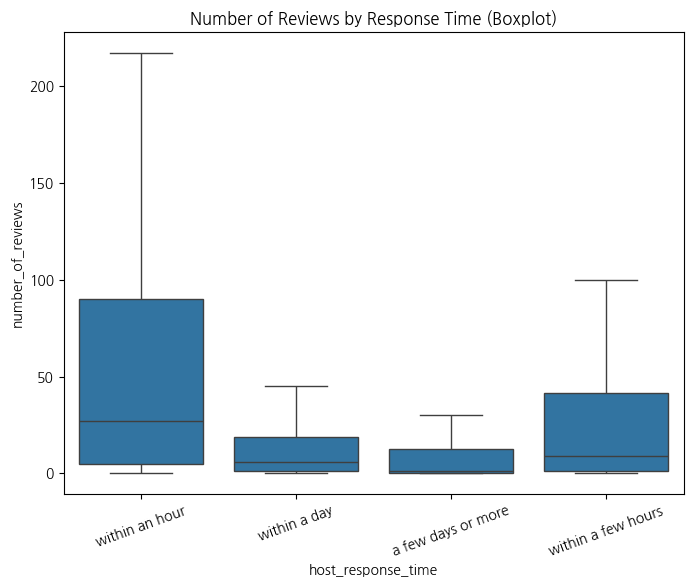

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.boxplot(x='host_response_time', y='number_of_reviews', data=df_non_missing, showfliers=False)
plt.title("Number of Reviews by Response Time (Boxplot)")
plt.xticks(rotation=20)
plt.show()

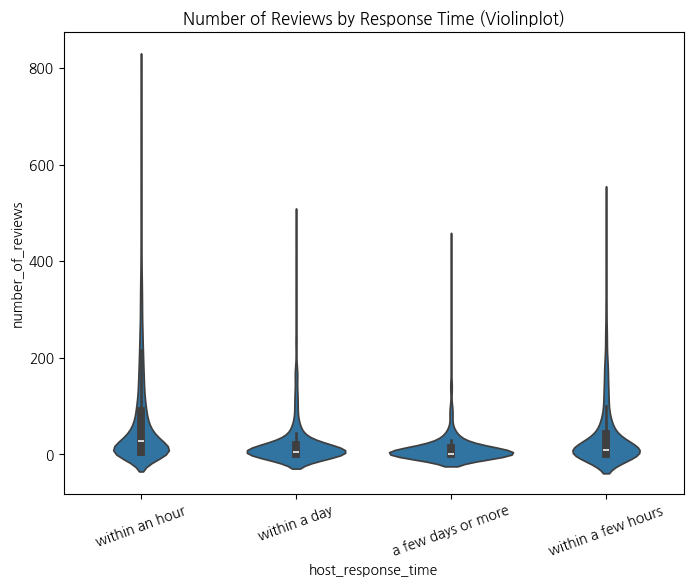

In [29]:
plt.figure(figsize=(8,6))
sns.violinplot(x='host_response_time', y='number_of_reviews', data=df_non_missing, inner="box")
plt.title("Number of Reviews by Response Time (Violinplot)")
plt.xticks(rotation=20)
plt.show()

앞서 확인한 산점도보다 더 큰 연관 관계를 보이는 듯한 차트?!

In [30]:
# 그룹별 Shapiro-Wilk 검정 (정규성)
print("=== Shapiro-Wilk 정규성 검정 ===")
for group, grp_df in df_non_missing.groupby("host_response_time"):
    stat, p = stats.shapiro(grp_df["number_of_reviews"])
    print(f"[{group}] W={stat:.3f}, p={p:.3e}")

print("\n=== Levene 등분산성 검정 ===")
# Levene’s test (등분산성) → 여러 그룹 동시에
groups = [grp["number_of_reviews"].values
          for _, grp in df_non_missing.groupby("host_response_time")]
stat, p = stats.levene(*groups)
print(f"Levene’s test: stat={stat:.3f}, p={p:.3e}")

=== Shapiro-Wilk 정규성 검정 ===
[a few days or more] W=0.371, p=1.439e-29
[within a day] W=0.482, p=2.282e-35
[within a few hours] W=0.591, p=1.749e-38
[within an hour] W=0.684, p=1.075e-82

=== Levene 등분산성 검정 ===
Levene’s test: stat=69.462, p=1.888e-44


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8449.
  res = hypotest_fun_out(*samples, **kwds)


정규분포(Shapiro–Wilk), 등분산성(Levene) 모두 만족 X -> **Kruskal–Wallis test**

In [32]:
# Kruskal-Wallis
import scipy.stats as stats

groups = [grp['number_of_reviews'].values
          for _, grp in df_non_missing.groupby('host_response_time')]

statistic, p_value = stats.kruskal(*groups)

print(f"P-값: {p_value:.3e}")
print(f"Kruskal-Wallis 검정 통계량: {statistic:.3f}")

P-값: 7.152e-109
Kruskal-Wallis 검정 통계량: 503.803


**host_response_time 그룹 간 리뷰 수 분포 차이가 통계적으로 매우 유의함을 확인**

##number_of_reviews vs host_acceptance_rate
둘 다 연속형 → 1번과 동일. 선형회귀 + 보조로 상관분석

In [33]:
X = df_non_missing['host_acceptance_rate']
Y = df_non_missing['number_of_reviews']


import scipy.stats as stats

pearson_r, pearson_p = stats.pearsonr(X, Y)
spearman_r, spearman_p = stats.spearmanr(X, Y)

print(f"Pearson r = {pearson_r:.3f}, p = {pearson_p:.3e}")
print(f"Spearman rho = {spearman_r:.3f}, p = {spearman_p:.3e}")

Pearson r = 0.157, p = 7.891e-56
Spearman rho = 0.249, p = 2.992e-140


In [34]:
import statsmodels.api as sm

X = sm.add_constant(df_non_missing['host_acceptance_rate']) #절편 추가
Y = df_non_missing['number_of_reviews']

model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      number_of_reviews   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     250.9
Date:                Sun, 21 Sep 2025   Prob (F-statistic):           7.89e-56
Time:                        08:36:16   Log-Likelihood:                -60091.
No. Observations:                9953   AIC:                         1.202e+05
Df Residuals:                    9951   BIC:                         1.202e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -13.6091      5.081     -2.678      0.007     -23.569      -3.649
host_acceptance_rate     0.8548      0.054     15.840      0.000       0.749       0.961
==============================================================================
Omnibus:                     5432.918   Durbin-Watson:                   1.111
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            39096.420
Skew:                           2.591   Prob(JB):                         0.00
Kurtosis:                      11.211   Cond. No.                         471.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

피어슨, 스피어만: 양의 상관 관계를 확인. 통계적으로는 유의하지만,   데이터가 워낙 크다 보니 작은 효과도 유의하게 잡힌 것일 뿐, 설명력이 약 2.5%밖에 안 됨.
즉, 수락률 하나만으로는 리뷰 수 변동을 거의 설명하지 못 함

#중간 결론:  
응답률, 수락률은 단일 지표로 리뷰 수를 설명하는 힘이 극히 약하다.  
응답시간이나 호스팅 기간 같은 다른 변수까지 포함한 다중 회귀를 돌려보는 것이 필요

#VIF 다중공선성 확인

In [31]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 분석할 변수들 (응답률, 응답시간 점수, 호스팅 수락률)
features = ['host_response_rate', 'host_response_time_score',
            'host_acceptance_rate']

X = df_non_missing[features].copy()
X = sm.add_constant(X)  # 절편 추가

# VIF 계산
vif_df = pd.DataFrame()
vif_df["Variable"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_df

,Variable,VIF
0,const,45.589229
1,host_response_rate,2.247829
2,host_response_time_score,2.631926
3,host_acceptance_rate,1.981033


모든 값들이 5점 미만이라 다중공선성 문제는 없음. 다만 생각해보니 비슷한 변수 둘이 있어서 그 둘 끼리 다시 VIF 확인

In [32]:
df_non_missing[['host_response_rate','host_response_time_score']].corr()


,host_response_rate,host_response_time_score
host_response_rate,1.000000,0.728084
host_response_time_score,0.728084,1.000000


수치는 작게 나왔지만.. 비슷한 수치이기때문에 둘 중 host_response_rate 는 변수로써 버리는 것으로

#다중 회귀

In [33]:
# 독립변수
features = ['host_response_time_score',
            'host_acceptance_rate']

X = df_non_missing[features].copy()
X = sm.add_constant(X)   # 절편 추가

# 종속변수
y = df_non_missing['number_of_reviews']

# OLS 회귀모델 적합
model = sm.OLS(y, X).fit()

# 결과 요약
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      number_of_reviews   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     142.0
Date:                Sun, 21 Sep 2025   Prob (F-statistic):           1.52e-61
Time:                        14:28:13   Log-Likelihood:                -60074.
No. Observations:                9953   AIC:                         1.202e+05
Df Residuals:                    9950   BIC:                         1.202e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                      -31.1689      5.939     -5.248      0.000     -42.810     -19.528
host_response_time_score    11.7527      2.066      5.688      0.000       7.702      15.803
host_acceptance_rate         0.5681      0.074      7.698      0.000       0.423       0.713
==============================================================================
Omnibus:                     5423.750   Durbin-Watson:                   1.109
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38969.117
Skew:                           2.586   Prob(JB):                         0.00
Kurtosis:                      11.198   Cond. No.                         562.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#다중 회귀도 값이 굉장히 낮게 나왔음.....
세 변수 중 가장 의미 있던 ```host_response_time```에 대해 더 깊게 파헤쳐보자...

##number_of_reviews vs host_response_time 사후 검정 - Dunn’s test (비모수)

In [34]:
!pip install scikit-posthocs


In [35]:
import scikit_posthocs as sp

# Dunn’s test (Bonferroni 보정)
dunn_result = sp.posthoc_dunn(
    df_non_missing,
    val_col='number_of_reviews',
    group_col='host_response_time',
    p_adjust='bonferroni'
)

dunn_result

,a few days or more,within a day,within a few hours,within an hour
a few days or more,1.000000e+00,1.344751e-04,1.669159e-13,6.898771e-54
within a day,1.344751e-04,1.000000e+00,9.887923e-04,1.793628e-42
within a few hours,1.669159e-13,9.887923e-04,1.000000e+00,2.481833e-27
within an hour,6.898771e-54,1.793628e-42,2.481833e-27,1.000000e+00


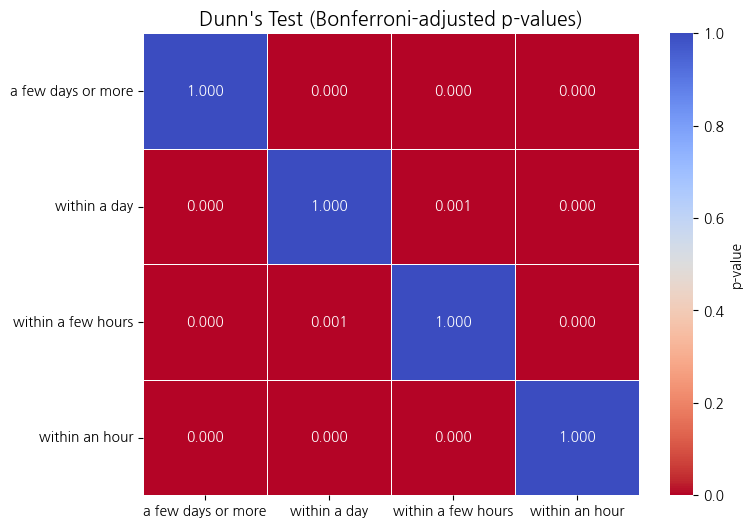

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(
    dunn_result,
    annot=True,          # p-값 숫자로 표시
    fmt=".3f",           # 소수점 3자리
    cmap="coolwarm_r",   # 색상 (빨강-파랑 반전)
    cbar_kws={'label': 'p-value'},
    linewidths=0.5
)
plt.title("Dunn's Test (Bonferroni-adjusted p-values)", fontsize=14)
plt.yticks(rotation=0)
plt.show()

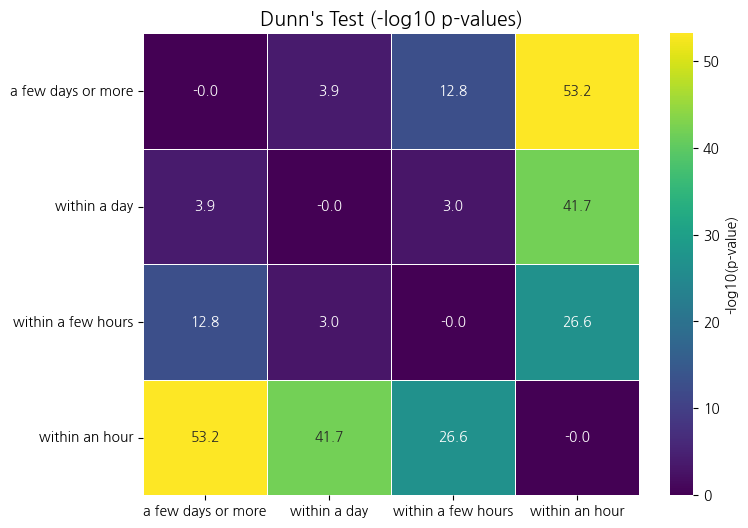

In [37]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# -log10 변환 (p=0이면 아주 작은 값으로 대체)
log_p = -np.log10(dunn_result.replace(0, 1e-300))

plt.figure(figsize=(8,6))
sns.heatmap(
    log_p,
    annot=True,
    fmt=".1f",
    cmap="viridis",
    cbar_kws={'label': '-log10(p-value)'},
    linewidths=0.5
)
plt.title("Dunn's Test (-log10 p-values)", fontsize=14)
plt.yticks(rotation=0)
plt.show()

“Dunn’s test 사후검정 결과, 응답시간 그룹 간 리뷰 수 분포는 모두 통계적으로 유의한 차이를 보였다(p<0.001). 특히 within an hour 그룹은 다른 모든 그룹보다 리뷰 수가 유의하게 많았다

그렇다면 within an hour는 어떤 그룹일지 궁금해진다... 평점도 높은건지 추가 확인해보자

In [41]:
df_non_missing['review_scores_rating'].isnull().sum()

np.int64(1049)

In [42]:
df_non_missing['review_scores_rating'].shape

(9953,)

/tmp/ipython-input-601046247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-601046247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-601046247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-601046247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-601046247.py:22: FutureWarning: 

Passing `pa

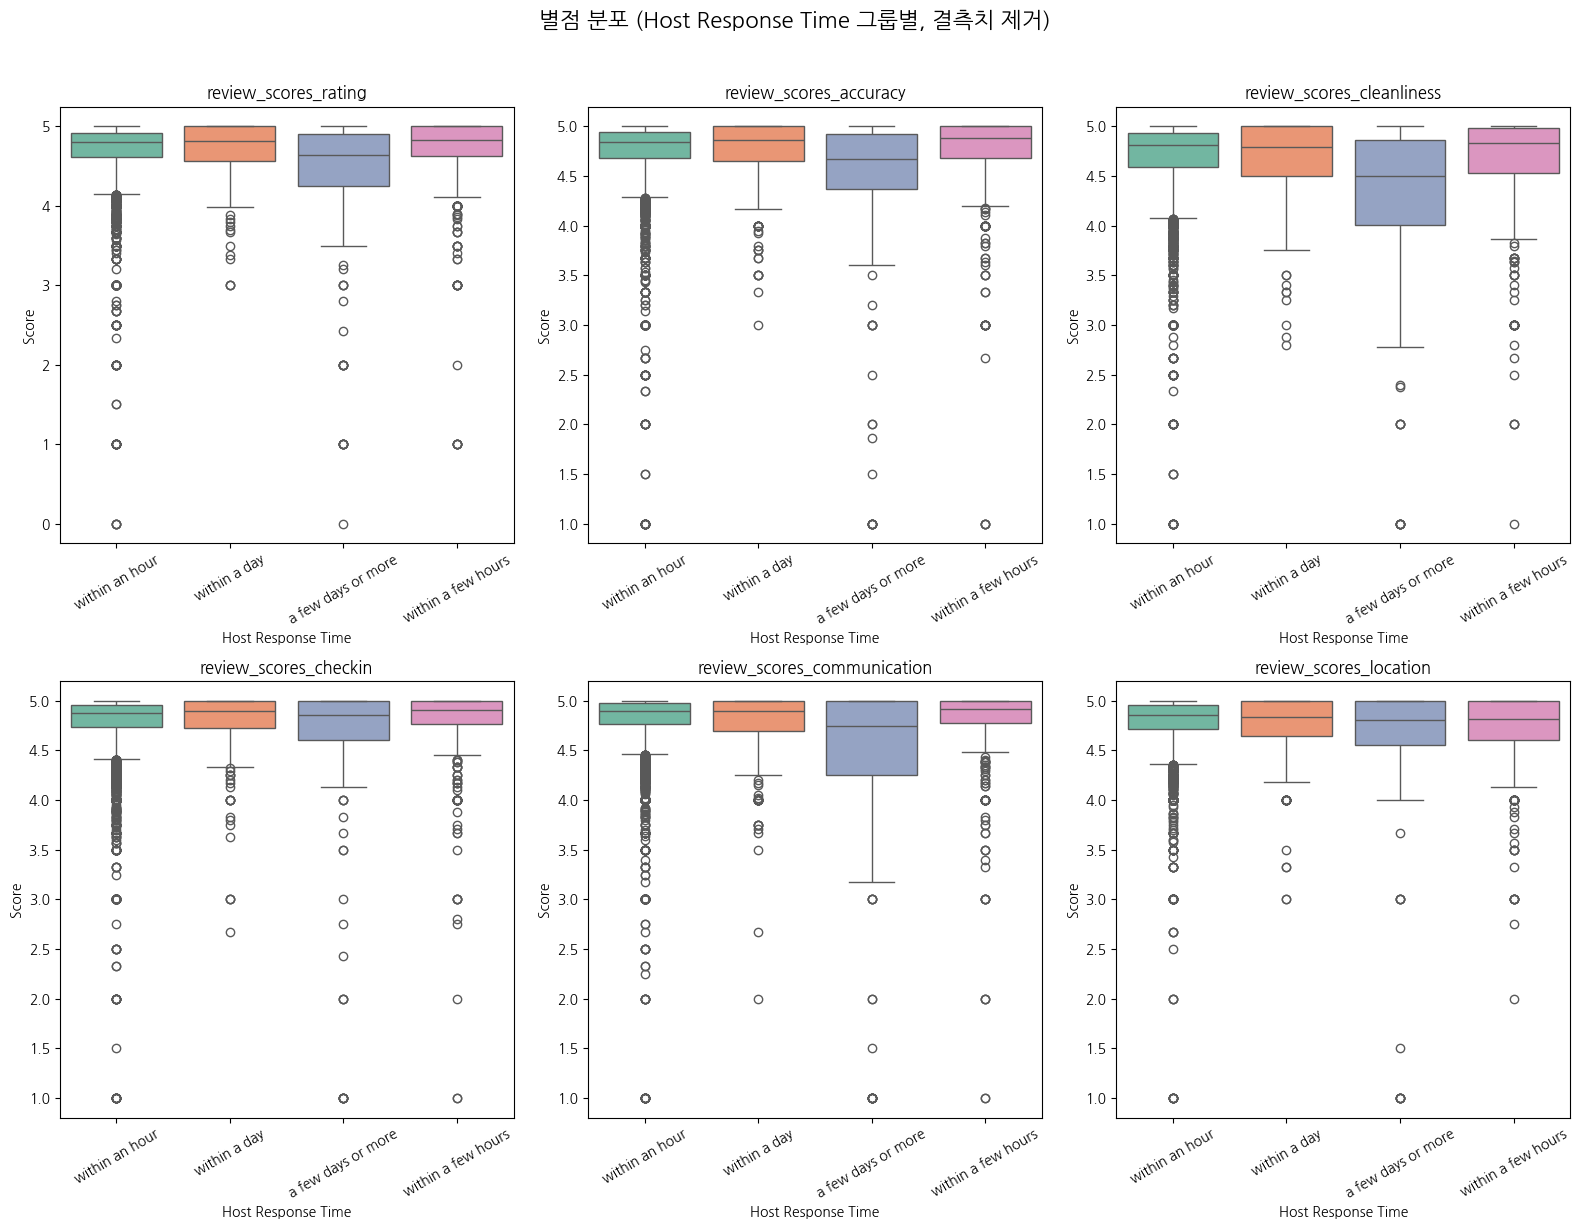

In [43]:
#그룹별 별점을 박스 플롯으로 시각화. (변수별 결측치 제거함)

import matplotlib.pyplot as plt
import seaborn as sns

# 시각화할 컬럼 목록
score_fields = [
    "review_scores_rating",
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_location"
]

plt.figure(figsize=(16, 12))

for i, col in enumerate(score_fields, 1):
    plt.subplot(2, 3, i)

    # 각 변수별 결측치 제거 후 박스플롯
    sns.boxplot(
        data=df_non_missing.dropna(subset=[col]),
        x="host_response_time",
        y=col,
        palette="Set2"
    )

    plt.title(col, fontsize=12)
    plt.xlabel("Host Response Time")
    plt.ylabel("Score")
    plt.xticks(rotation=30)

plt.suptitle("별점 분포 (Host Response Time 그룹별, 결측치 제거)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()



a few days or more이 박스가 다른 그룹에 비해 긺
- 해석: 게스트가 호스트의 응답을 며칠 이상 기다려야 하는 경우, 만족도가 들쑥날쑥
근데 within an hour도 박스 외에 찍힌 점들이 너무너무 많음
- 해석: 이 그룹 내에서도 **극단적인 경험(매우 불만족 or 매우 만족)**을 한 게스트가 적지 않았음.

종합: **빠른 응답(1시간 이내)**이 '평균적'으로는 좋은 평가와 연결되지만,  
오히려 기대치가 높아서 조금만 불편해도 낮은 점수를 주는 게스트가 꽤 있었을지도?  
반대로 느린 응답 그룹은 전반적으로 기대치가 낮아 분산이 클 수도?

In [47]:
summary = df_non_missing.groupby("host_response_time")[score_fields].agg(["mean", "std"]) #median, count

summary.round(2)

review_scores_rating       review_scores_accuracy        \
                                   mean   std                   mean   std   
host_response_time                                                           
a few days or more                 4.29  1.03                   4.35  0.99   
within a day                       4.71  0.35                   4.75  0.33   
within a few hours                 4.68  0.53                   4.73  0.48   
within an hour                     4.70  0.39                   4.75  0.36   

                   review_scores_cleanliness       review_scores_checkin  \
                                        mean   std                  mean   
host_response_time                                                         
a few days or more                      4.21  0.97                  4.52   
within a day                            4.66  0.39                  4.80   
within a few hours                      4.65  0.51                  4.79   
within an hour                          4.69  0.39                  4.78   

                         review_scores_communication        \
                     std                        mean   std   
host_response_time                                           
a few days or more  0.93                        4.35  1.04   
within a day        0.31                        4.77  0.35   
within a few hours  0.40                        4.78  0.43   
within an hour      0.34                        4.80  0.33   

                   review_scores_location        
                                     mean   std  
host_response_time                               
a few days or more                   4.56  0.83  
within a day                         4.75  0.30  
within a few hours                   4.72  0.36  
within an hour                       4.79  0.28

In [46]:
summary_stacked = summary.stack(level=0)   # 변수명을 세로축으로
display(summary_stacked)

/tmp/ipython-input-1364143555.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  summary_stacked = summary.stack(level=0)   # 변수명을 세로축으로


mean  median       std  \
host_response_time                                                           
a few days or more review_scores_accuracy       4.347669   4.670  0.992652   
                   review_scores_checkin        4.523620   4.860  0.928049   
                   review_scores_cleanliness    4.212761   4.500  0.969565   
                   review_scores_communication  4.346074   4.750  1.043814   
                   review_scores_location       4.564785   4.810  0.829767   
                   review_scores_rating         4.287988   4.640  1.030438   
within a day       review_scores_accuracy       4.751468   4.860  0.328359   
                   review_scores_checkin        4.802264   4.900  0.305174   
                   review_scores_cleanliness    4.661866   4.795  0.388987   
                   review_scores_communication  4.765100   4.900  0.352606   
                   review_scores_location       4.754055   4.835  0.304740   
                   review_scores_rating         4.707114   4.820  0.353507   
within a few hours review_scores_accuracy       4.727021   4.880  0.478530   
                   review_scores_checkin        4.786323   4.910  0.397168   
                   review_scores_cleanliness    4.645024   4.830  0.512434   
                   review_scores_communication  4.784596   4.920  0.429558   
                   review_scores_location       4.721173   4.820  0.364312   
                   review_scores_rating         4.679684   4.830  0.529562   
within an hour     review_scores_accuracy       4.748842   4.840  0.361263   
                   review_scores_checkin        4.782918   4.880  0.341223   
                   review_scores_cleanliness    4.691727   4.810  0.393378   
                   review_scores_communication  4.802662   4.900  0.333582   
                   review_scores_location       4.791471   4.860  0.281703   
                   review_scores_rating         4.698802   4.800  0.391910   

                                                count  
host_response_time                                     
a few days or more review_scores_accuracy         163  
                   review_scores_checkin          163  
                   review_scores_cleanliness      163  
                   review_scores_communication    163  
                   review_scores_location         163  
                   review_scores_rating           164  
within a day       review_scores_accuracy         402  
                   review_scores_checkin          402  
                   review_scores_cleanliness      402  
                   review_scores_communication    402  
                   review_scores_location         402  
                   review_scores_rating           402  
within a few hours review_scores_accuracy         631  
                   review_scores_checkin          631  
                   review_scores_cleanliness      631  
                   review_scores_communication    631  
                   review_scores_location         631  
                   review_scores_rating           632  
within an hour     review_scores_accuracy        7684  
                   review_scores_checkin         7684  
                   review_scores_cleanliness     7685  
                   review_scores_communication   7685  
                   review_scores_location        7684  
                   review_scores_rating          7706

In [48]:
# 필요한 패키지
from scipy.stats import kruskal
import scikit_posthocs as sp
import numpy as np
import pandas as pd

group_col = "host_response_time"

kw_results = {}          # 각 항목의 Kruskal–Wallis p-값
dunn_results = {}        # 각 항목의 Dunn’s test p-값 행렬(DataFrame)
winner_summary = []      # 항목별 “최고 그룹” 판정 요약

for col in score_fields:
    # 해당 항목의 결측치만 제거
    sub = df_non_missing[[group_col, col]].dropna()
    # 그룹별 값 리스트
    groups = [g[col].values for _, g in sub.groupby(group_col)]
    labels = list(sub[group_col].unique())

    # 1) Kruskal–Wallis
    stat, p = kruskal(*groups)
    kw_results[col] = p

    # 2) Dunn’s test (Bonferroni 보정)
    dunn = sp.posthoc_dunn(sub, val_col=col, group_col=group_col, p_adjust="bonferroni")
    dunn.index.name = dunn.columns.name = group_col
    dunn_results[col] = dunn

    # 3) “가장 나은 그룹” 판정 로직 (중앙값 기준 + 모든 쌍과 유의 차이)
    med = sub.groupby(group_col)[col].median().sort_values(ascending=False)
    top = med.index[0]                         # 중앙값이 가장 큰 그룹
    # top이 나머지 모든 그룹보다 유의하게 높은가?
    # (쌍별 p<0.05 이면서 top 중앙값 >= 상대 중앙값)
    is_top_sig = True
    for other in med.index[1:]:
        p_pair = dunn.loc[top, other] if top in dunn.index and other in dunn.columns else dunn.loc[other, top]
        if not (p_pair < 0.05 and med.loc[top] >= med.loc[other]):
            is_top_sig = False
            break

    winner_summary.append({
        "metric": col,
        "kw_pvalue": p,
        "top_by_median": top,
        "top_median": float(med.loc[top]),
        "is_top_significantly_higher_vs_all": is_top_sig,
    })

# 4) 요약 테이블
summary_df = pd.DataFrame(winner_summary).sort_values("metric")
summary_df["kw_pvalue"] = summary_df["kw_pvalue"].map(lambda x: f"{x:.2e}")
summary_df


,metric,kw_pvalue,top_by_median,top_median,is_top_significantly_higher_vs_all
1,review_scores_accuracy,1.70e-09,within a few hours,4.88,False
3,review_scores_checkin,7.58e-07,within a few hours,4.91,False
2,review_scores_cleanliness,3.62e-11,within a few hours,4.83,False
4,review_scores_communication,1.02e-09,within a few hours,4.92,False
5,review_scores_location,6.15e-03,within an hour,4.86,False
0,review_scores_rating,1.00e-08,within a few hours,4.83,False


In [49]:
import numpy as np

relative_summary = []

for col in score_fields:
    sub = df_non_missing[[group_col, col]].dropna()
    dunn = dunn_results[col]

    counts = {grp: 0 for grp in dunn.index}
    for g1 in dunn.index:
        for g2 in dunn.columns:
            if g1 != g2:
                if dunn.loc[g1, g2] < 0.05:
                    # g1이 g2보다 중앙값이 높다면 카운트 +1
                    if sub.groupby(group_col)[col].median()[g1] > sub.groupby(group_col)[col].median()[g2]:
                        counts[g1] += 1
    relative_summary.append({"metric": col, **counts})

pd.DataFrame(relative_summary)

,metric,a few days or more,within a day,within a few hours,within an hour
0,review_scores_rating,0,1,2,1
1,review_scores_accuracy,0,1,2,1
2,review_scores_cleanliness,0,1,1,1
3,review_scores_checkin,0,2,2,0
4,review_scores_communication,0,1,2,1
5,review_scores_location,0,0,0,1


------


> 변수별로 리뷰 수 차이가 있냐를 통계적으로 확인했음. 다음부터는 “리뷰가 적은 호스트를 식별할 수 있냐”라는 예측문제로 바꿔서 생각

**운영 전략(users 대시보드 노출 방향)** 에 연결 가능

#부가 시각화
리뷰 수와 연관이 있는 다른 데이터로 무엇이 있을까?

<Figure size 1200x600 with 0 Axes>

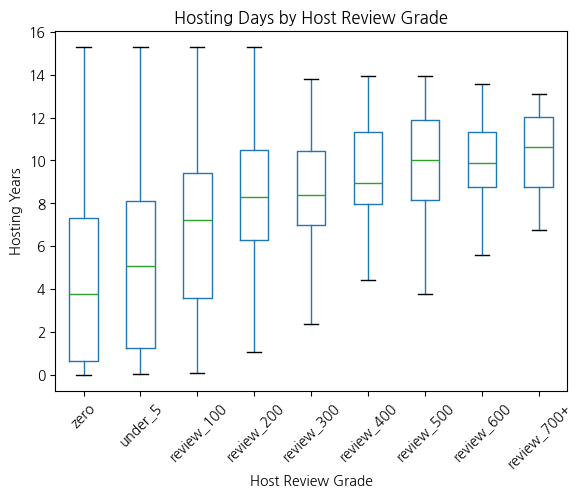

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
df_clean.boxplot(
    column="hosting_years",
    by="host_review_grade",
    grid=False,
    showfliers=False   # 이상치 점 안 보이게 해서 전체 분포가 더 잘 보이게
)
plt.title("Hosting Days by Host Review Grade")
plt.suptitle("")  # 기본 타이틀 제거
plt.xlabel("Host Review Grade")
plt.ylabel("Hosting Years")
plt.xticks(rotation=45)
plt.show()

리뷰가 적은 호스트는 운영 기간의 차이가 크다 → “운영 기간만 길다고 리뷰가 쌓이지는 않는다.”  
리뷰가 많은 호스트는 운영 기간의 차이가 상대적으로 작다 → 리뷰 성과가 좋은 호스트들은 기간 패턴이 비슷하다..?

<Figure size 1200x600 with 0 Axes>

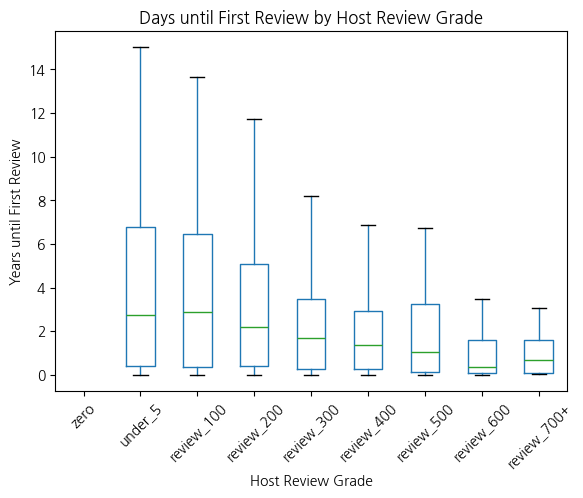

In [31]:
plt.figure(figsize=(12,6))
df_clean.boxplot(
    column="til_first_review_years",
    by="host_review_grade",
    grid=False,
    showfliers=False   # 극단치 제외하면 전반적 분포가 잘 보임
)
plt.title("Days until First Review by Host Review Grade")
plt.suptitle("")  # 기본 타이틀 제거
plt.xlabel("Host Review Grade")
plt.ylabel("Years until First Review")
plt.xticks(rotation=45)
plt.show()

review_500+ 그룹으로 갈수록 박스가 급격히 짧아짐 (첫 리뷰 받기까지 기간이 짧음)
즉, 첫 리뷰를 빨리 받은 호스트가 장기적으로도 리뷰를 더 많이 쌓는 경향이 관찰됨.
###호스팅을 시작하고 단기간 내에 첫 리뷰를 받는 것이 더 많은 리뷰를 축적하게 하며결국 더 오랜 기간 호스팅을 할 수 있는 동력이 되는 것은 아닐지??

GPT says
리뷰 수가 많을수록 첫 리뷰까지 걸린 기간이 짧고 일관적.

고성과 호스트들의 공통 패턴은: “첫 리뷰 ≤ 1년”.

첫 리뷰까지 지연된 호스트는 장기적으로도 저성과군일 가능성이 높음.


In [56]:
df_non_missing['number_of_reviews'].isnull().sum()

#몇년 걸렸는지 값이 없는 경우가 1051개나 있음....

np.int64(0)

In [58]:
# 1) Spearman 상관 (리뷰 ≥1 & til_first_review_years 존재)
from scipy import stats

df_corr = df_non_missing[
    (df_non_missing['number_of_reviews'] > 0) &
    (df_non_missing['til_first_review_years'].notna())
].copy()

rho, p = stats.spearmanr(
    df_corr['number_of_reviews'],
    df_corr['til_first_review_years']
)
print(f"Spearman rho = {rho:.3f}, p = {p:.3e}, n = {len(df_corr)}")


Spearman rho = -0.130, p = 4.549e-35, n = 8902


음의 상관 → 첫 리뷰까지 걸린 시간이 짧을수록, 장기적으로 리뷰 수가 많다. 다만 상관계수 절대값이 0.13이므로, 관계는 약하다.
표본 수가 크기(n=8,902) 때문에 아주 작은 차이도 통계적으로는 강하게 유의. (먼말이냐..)

In [59]:
# 2) df_clean에서 "리뷰는 있는데 날짜가 없어 til_first_review_years가 NaN"인 케이스 카운트
mask_weird = (
    (df_clean['number_of_reviews'] > 0) &
    (df_clean['til_first_review_years'].isna())
)
n_weird = mask_weird.sum()
n_total = len(df_clean)
print(f"리뷰>0 & til_first_review_years=NaN: {n_weird}개 ({n_weird/n_total:.2%})")

# 참고: 리뷰가 0이고 til_first_review_years가 NaN인 정상 케이스도 같이 확인
mask_zero = (
    (df_clean['number_of_reviews'] == 0) &
    (df_clean['til_first_review_years'].isna())
)
print(f"리뷰=0 & til_first_review_years=NaN: {mask_zero.sum()}개")

# 필요하면 어떤 행들인지 샘플 확인
# display(df_clean.loc[mask_weird].head())


리뷰>0 & til_first_review_years=NaN: 0개 (0.00%)
리뷰=0 & til_first_review_years=NaN: 1497개


#친구 says  


📌 지금까지 나온 근거

응답 시간

Dunn’s test 결과 → 응답이 빠를수록 리뷰 수가 유의하게 많음.

즉, “하루 안에” (특히 within an hour) 응답하는 게 리뷰 성장에 유리.

첫 리뷰까지 걸린 기간

Spearman 상관(rho=-0.13, p≪0.001) → 첫 리뷰가 빨리 달린 호스트일수록 리뷰 수가 많음.

박스플롯에서도 첫 리뷰 ≤ 1년 이내 확보한 호스트가 장기적으로 고성과 그룹으로 가는 경향 확인.

👉 결론: 빠른 응답 + 빠른 첫 리뷰 확보 = 장기 리뷰 성장의 핵심 패턴

📊 목표 재설정 (이제 막 시작하는 호스트 키우기)

행동 가이드라인

응답 목표: 무조건 하루 이내(ideally within an hour).

첫 리뷰 목표: 가능하다면 몇 달 이내, 늦어도 1년 안에 첫 리뷰 확보.

운영 전략 예시

신입 호스트에겐 자동화 메시지로 “첫 문의는 무조건 1시간 안에 답하세요” 교육.

가격 프로모션, 신규 게스트 유치 이벤트, 리뷰 인센티브 → 첫 리뷰 확보 속도를 앞당김.

📌 머신러닝 관점 연결

머신러닝 모델을 쓰면:

리뷰 부족 위험군 예측

low_review_flag (under_5 여부) 분류 모델 → 리뷰 부족할 가능성 높은 신입 호스트 미리 식별.

정책 시뮬레이션

모델에 “응답시간=within an hour” vs “a few days” 넣어서 예측 비교 → 응답 개선이 리뷰 성장 확률에 얼마나 기여하는지 추정 가능.

✅ 정리

네가 설정한 골:
“응답을 하루 이내로 유지하고, 첫 리뷰를 최대한 빨리 받게 하는 것”

이건 지금까지의 분석 결과랑 완전히 일치하고, 실제 Airbnb 운영전략에도 부합합니다.

머신러닝은 이걸 개별 호스트 단위로 확률화해서 “이 호스트는 리뷰 부족 위험이 높다 → 부스팅 대상” 이렇게 쓰는 거예요.

In [62]:
#----------------

In [64]:
#----------------

In [66]:
#----------------

#⏯ ⏯ ⏯ ⏯ ⏯ ⏯ ⏯ ⏯ ⏯ ⏯

여기서 일단 til_first_review_years 이랑 host_review_graded을 검정

단 host_review_grade == "zero" & til_first_review_days가 NaN인 경우 제외

In [32]:
# 'zero' 그룹이면서 첫 리뷰일수 결측치인 행 제거
mask = ~((df_clean['host_review_grade'] == 'zero') & (df_clean['til_first_review_years'].isna()))
df_valid = df_clean[mask].copy()

print("원래 데이터 크기:", df_clean.shape)
print("필터링 후 데이터 크기:", df_valid.shape)

# 다시 그룹별로 til_first_review_days vs host_review_grade 검정
import scipy.stats as stats

data = df_valid[['til_first_review_years', 'host_review_grade']].dropna()

groups = []
valid_labels = []
for name, grp in data.groupby('host_review_grade'):
    vals = grp['til_first_review_years'].values
    if len(vals) > 0:
        groups.append(vals)
        valid_labels.append(name)

print("검정에 사용된 그룹:", valid_labels)

if len(groups) >= 2:
    anova_stat, anova_p = stats.f_oneway(*groups)
    print("\nANOVA 결과")
    print(f"F-statistic: {anova_stat:.3f}, p-value: {anova_p:.3e}")

    kw_stat, kw_p = stats.kruskal(*groups)
    print("\nKruskal-Wallis 결과")
    print(f"H-statistic: {kw_stat:.3f}, p-value: {kw_p:.3e}")
else:
    print("⚠️ 유효한 그룹이 2개 미만이라 통계 검정을 할 수 없습니다.")


원래 데이터 크기: (11446, 81)
필터링 후 데이터 크기: (9949, 81)
검정에 사용된 그룹: ['under_5', 'review_100', 'review_200', 'review_300', 'review_400', 'review_500', 'review_600', 'review_700+']

ANOVA 결과
F-statistic: 43.207, p-value: 1.604e-60

Kruskal-Wallis 결과
H-statistic: 221.716, p-value: 2.852e-44


/tmp/ipython-input-1714500222.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, grp in data.groupby('host_review_grade'):


In [34]:
#number_of_reviews랑 til_first_review_years 간의 상관 관계 검정


# number_of_reviews > 0 인 데이터만 추출
df_corr = df_clean[(df_clean['number_of_reviews'] > 0)][['number_of_reviews', 'til_first_review_years']].dropna()

# 피어슨 상관계수 (선형 관계)
pearson_r, pearson_p = stats.pearsonr(df_corr['number_of_reviews'], df_corr['til_first_review_years'])
print("Pearson 상관분석 결과")
print(f"r = {pearson_r:.3f}, p-value = {pearson_p:.3e}")

# 스피어만 순위 상관계수 (비선형·순위 기반)
spearman_r, spearman_p = stats.spearmanr(df_corr['number_of_reviews'], df_corr['til_first_review_years'])
print("\nSpearman 상관분석 결과")
print(f"rho = {spearman_r:.3f}, p-value = {spearman_p:.3e}")




#상관계수 크기 자체는 매우 약함 (–0.1 ~ –0.2 수준) → 설명력은 높지 않음.
#하지만 p-value가 매우 작아서 “우연이 아님”은 확실.
#해석: 숙소를 운영하다가 리뷰를 빨리 받은 호스트일수록 장기적으로 리뷰 수가 많이 쌓이는 경향이 있다~

Pearson 상관분석 결과
r = -0.173, p-value = 1.468e-67

Spearman 상관분석 결과
rho = -0.110, p-value = 5.999e-28


In [36]:
import pandas as pd
import scipy.stats as stats

results = []

# 리뷰가 1개 이상인 데이터만 사용
df_sub = df_clean[df_clean['number_of_reviews'] > 0].copy()

for grade, grp in df_sub.groupby("host_review_grade"):
    data = grp[['number_of_reviews', 'til_first_review_years']].dropna()
    if len(data) > 5:  # 표본 너무 작은 그룹 제외
        pearson_r, pearson_p = stats.pearsonr(data['number_of_reviews'], data['til_first_review_years'])
        spearman_r, spearman_p = stats.spearmanr(data['number_of_reviews'], data['til_first_review_years'])
        results.append({
            "host_review_grade": grade,
            "n": len(data),
            "Pearson r": round(pearson_r, 3),
            "Pearson p": f"{pearson_p:.2e}",
            "Spearman rho": round(spearman_r, 3),
            "Spearman p": f"{spearman_p:.2e}"
        })

results_df = pd.DataFrame(results)
results_df


/tmp/ipython-input-3634293653.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for grade, grp in df_sub.groupby("host_review_grade"):


,host_review_grade,n,Pearson r,Pearson p,Spearman rho,Spearman p
0,under_5,1886,-0.013,5.75e-01,-0.020,3.94e-01
1,review_100,5881,-0.048,2.32e-04,-0.022,8.92e-02
2,review_200,1176,-0.073,1.18e-02,-0.052,7.21e-02
3,review_300,537,-0.052,2.29e-01,-0.054,2.09e-01
4,review_400,270,-0.183,2.48e-03,-0.159,8.93e-03
5,review_500,112,-0.117,2.21e-01,-0.075,4.30e-01
6,review_600,56,-0.085,5.34e-01,-0.166,2.20e-01
7,review_700+,31,-0.051,7.83e-01,0.417,1.97e-02


리뷰가 많을수록 첫 리뷰까지 걸린 시간이 약간 짧아지는 경향은 있으나, 효과 크기는 매우 약함
p-value가 작은 그룹은 유의하다고 볼 수 있지만, 상관계수 자체가 작으므로 설명력은 거의 없음
특히 review_400 그룹에서 음의 상관이 가장 뚜렷하게 나타남.
극단적 고리뷰 그룹(700+)은 표본이 적어 특이한 패턴(양의 상관)이 나타났지만 신뢰도는 낮음.


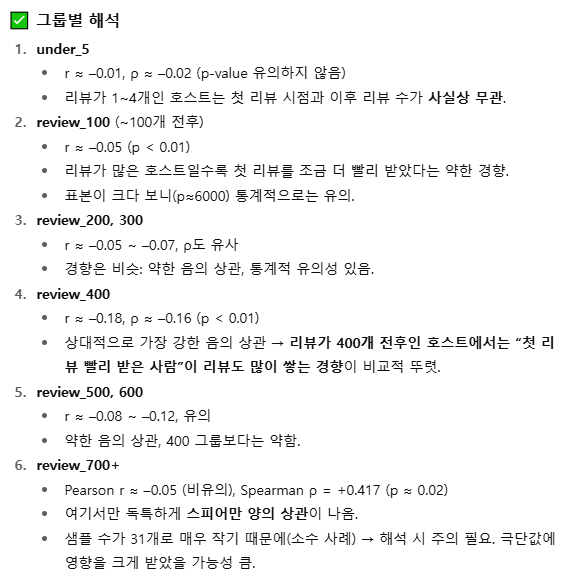

In [7]:
# 응답시간 점수화 (빠를수록 높은 점수)
resp_time_score_map = {
    "within an hour": 4,
    "within a few hours": 3,
    "within a day": 2,
    "a few days or more": 1
}

df_clean["host_response_time_score"] = df_clean["host_response_time"].map(resp_time_score_map)


In [22]:
check_response_time = df['host_response_time'].isnull().sum()
check_response_rate = df['host_response_rate'].isnull().sum()
check_time_rate =  (df['host_response_time'].isnull() & df['host_response_rate'].isnull()).sum()
check_acceptance_rate = df['host_acceptance_rate'].isnull().sum()

print("결측치 확인")
print(f"응답 시간 결측치: {check_response_time}")
print(f"응답 비율 결측치: {check_response_rate}")
print(f"응답 시간&비율 결측치: {check_time_rate}")
print(f"수락율 결측치: {check_acceptance_rate}")

결측치 확인
응답 시간 결측치: 1446
응답 비율 결측치: 1446
응답 시간&비율 결측치: 1446
수락율 결측치: 805


/tmp/ipython-input-2603762227.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('host_review_grade')[cols_to_check]


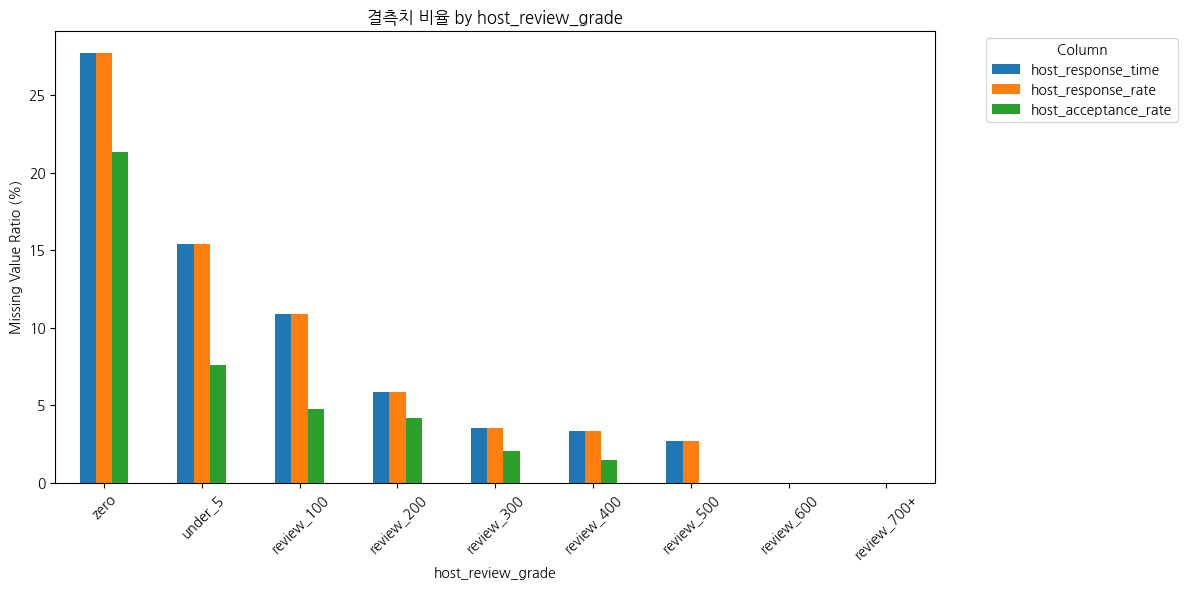

In [23]:
import matplotlib.pyplot as plt

# 그룹별 결측치 비율 계산
cols_to_check = ['host_response_time', 'host_response_rate', 'host_acceptance_rate']

# 각 그룹별 결측치 수 / 전체 수
group_nulls = (
    df_clean
    .groupby('host_review_grade')[cols_to_check]
    .apply(lambda x: x.isnull().mean() * 100)   # 비율(%)
)

# 시각화
group_nulls.plot(kind='bar', figsize=(12,6))
plt.ylabel("Missing Value Ratio (%)")
plt.title("결측치 비율 by host_review_grade")
plt.xticks(rotation=45)
plt.legend(title="Column", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

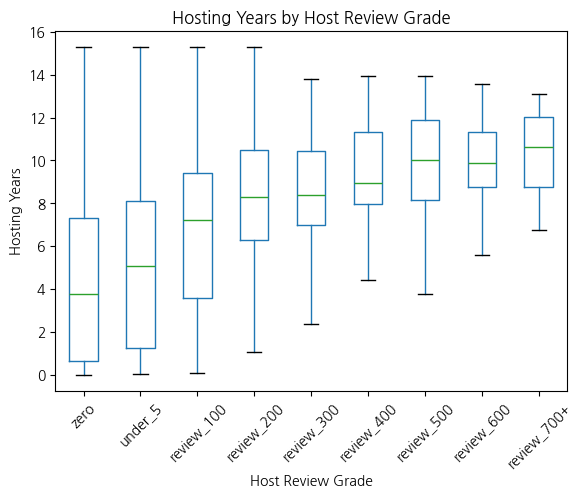

In [39]:
order = ["zero","under_5","review_100","review_200","review_300",
         "review_400","review_500","review_600","review_700+"]

tmp = (
    df_clean[["host_review_grade", "hosting_years"]]
    .dropna()
    .copy()
)
tmp["host_review_grade"] = pd.Categorical(tmp["host_review_grade"], categories=order, ordered=True)

plt.figure(figsize=(10,6))
ax = tmp.boxplot(column="hosting_years", by="host_review_grade",
                 grid=False, showfliers=False)
plt.title("Hosting Years by Host Review Grade")
plt.suptitle("")  # pandas 기본 상단 타이틀 제거
plt.xlabel("Host Review Grade")
plt.ylabel("Hosting Years")
plt.xticks(rotation=45)
plt.show()

TypeError: 'value' must be an instance of str or bytes, not a float

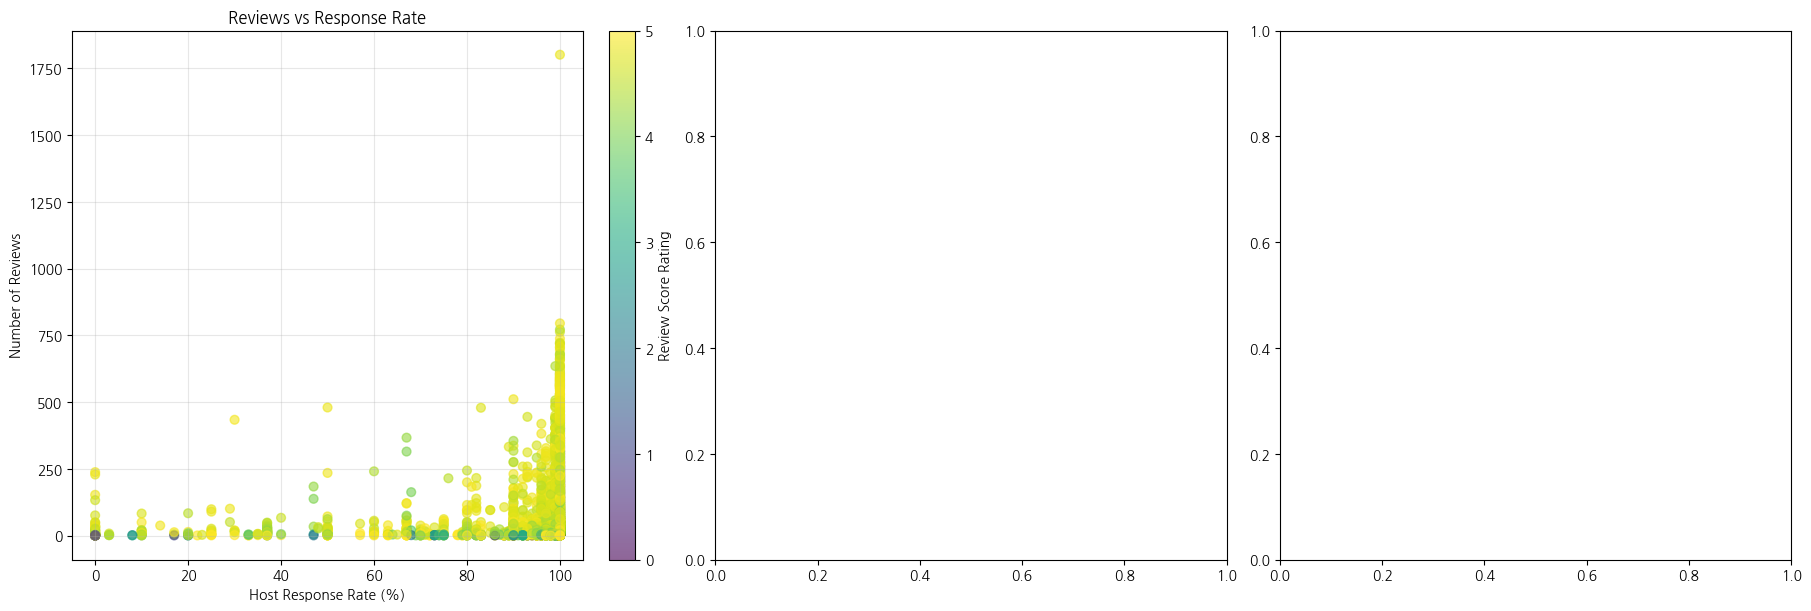

In [15]:
# 산점도 (가로축=응답률/응답시간/수락률, 세로축=리뷰 수)

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# (a) 응답률 vs 리뷰수
sc0 = axes[0].scatter(
    df_clean['host_response_rate'],
    df_clean['number_of_reviews'],
    c=df_clean['review_scores_rating'],
    cmap='viridis',
    alpha=0.6,
    s=40
)
fig.colorbar(sc0, ax=axes[0], label='Review Score Rating')
axes[0].set_xlabel('Host Response Rate (%)')
axes[0].set_ylabel('Number of Reviews')
axes[0].set_title('Reviews vs Response Rate')
axes[0].grid(True, alpha=0.3)


# (b) 응답시간 문자열 vs 리뷰수
sc1 = axes[1].scatter(
    df_clean['host_response_time'],
    df_clean['number_of_reviews'],
    c=df_clean['review_scores_rating'],
    cmap='viridis',
    alpha=0.6,
    s=40
)
fig.colorbar(sc1, ax=axes[1], label='Review Score Rating')
axes[1].set_xlabel('Host Response Time')
axes[1].set_ylabel('Number of Reviews')
axes[1].set_title('Reviews vs Response Time')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(
    ['within an hour','within a few hours','within a day','a few days or more']
)
axes[1].set_xticklabels(
    ['within an hour','within a few hours','within a day','a few days or more'],
    rotation=15
)

# (c) 수락률 vs 리뷰수
sc2 = axes[2].scatter(
    df_clean['host_acceptance_rate'],
    df_clean['number_of_reviews'],
    c=df_clean['review_scores_rating'],
    cmap='viridis',
    alpha=0.6,
    s=40
)
fig.colorbar(sc2, ax=axes[2], label='Review Score Rating')
axes[2].set_xlabel('Host Acceptance Rate (%)')
axes[2].set_ylabel('Number of Reviews')
axes[2].set_title('Reviews vs Acceptance Rate')
axes[2].grid(True, alpha=0.3)

plt.show()

In [6]:
df_clean.describe()

,id,scrape_id,last_scraped,host_id,host_since,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,...,license,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,hosting_days,hosting_years,til_first_review_days,til_first_review_years
count,1.144600e+04,1.144600e+04,11446,1.144600e+04,11446,10000.000000,10641.000000,11446.000000,11446.000000,0.0,...,0.0,11446.000000,11446.000000,11446.000000,11446.000000,9949.000000,11446.000000,11446.000000,9949.000000,9949.000000
mean,4.359394e+17,2.023782e+13,2024-02-11 23:36:05.787174400,1.952985e+08,2017-08-26 09:48:31.829460224,95.966800,91.487360,21.551372,37.146165,NaN,...,NaN,15.582037,12.787524,2.036956,0.634021,1.951463,2360.574699,6.462901,1260.362448,3.450684
min,3.884000e+03,2.023062e+13,2023-06-24 00:00:00,3.128000e+03,2008-09-23 00:00:00,0.000000,0.000000,0.000000,0.000000,NaN,...,NaN,1.000000,0.000000,0.000000,0.000000,0.010000,2.000000,0.005476,-1941.000000,-5.314168
25%,2.679793e+07,2.023122e+13,2023-12-20 00:00:00,2.320863e+07,2014-11-01 06:00:00,100.000000,96.000000,2.000000,3.000000,NaN,...,NaN,2.000000,1.000000,0.000000,0.000000,0.460000,1077.250000,2.949350,131.000000,0.358658
50%,5.435901e+07,2.024033e+13,2024-03-25 00:00:00,1.090892e+08,2016-12-30 00:00:00,100.000000,100.000000,6.000000,9.000000,NaN,...,NaN,6.000000,3.000000,0.000000,0.000000,1.350000,2598.500000,7.114305,884.000000,2.420260
75%,8.936214e+17,2.024033e+13,2024-03-25 00:00:00,3.804714e+08,2020-12-16 00:00:00,100.000000,100.000000,21.000000,28.000000,NaN,...,NaN,17.000000,13.000000,1.000000,0.000000,2.980000,3388.000000,9.275838,2231.000000,6.108145
max,1.119467e+18,2.024033e+13,2024-03-26 00:00:00,5.685152e+08,2024-03-23 00:00:00,100.000000,100.000000,2452.000000,5679.000000,NaN,...,NaN,96.000000,96.000000,59.000000,78.000000,26.190000,5577.000000,15.268994,5481.000000,15.006160
std,4.495003e+17,4.129187e+09,NaN,1.934857e+08,NaN,15.142458,20.532961,68.604070,218.460690,NaN,...,NaN,21.688780,20.728529,6.530952,6.719012,1.898202,1396.720340,3.824012,1224.851076,3.353459


In [7]:
df_clean.to_csv("Airbnb_clean.csv", index=False, encoding="utf-8-sig")

In [10]:
#호스팅 시작 이후 첫 리뷰 받기까지의 기간(years 기준)
# 그룹별 평균과 중앙값 계산
result = df_clean.groupby("host_review_grade")["til_first_review_years"].agg(["mean", "median"])

result

/tmp/ipython-input-2759599601.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = df_clean.groupby("host_review_grade")["til_first_review_years"].agg(["mean", "median"])


,mean,median
host_review_grade,,
zero,NaN,NaN
under_5,3.781236,2.740589
review_100,3.714425,2.888433
review_200,2.907027,2.114990
review_300,2.102313,1.648186
review_400,1.914042,1.330595
review_500,1.779114,0.997947
review_600,1.070060,0.347707
review_700+,1.010797,0.662560


/tmp/ipython-input-2813575544.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = filtered.groupby("host_review_grade")["til_first_review_years"].count()


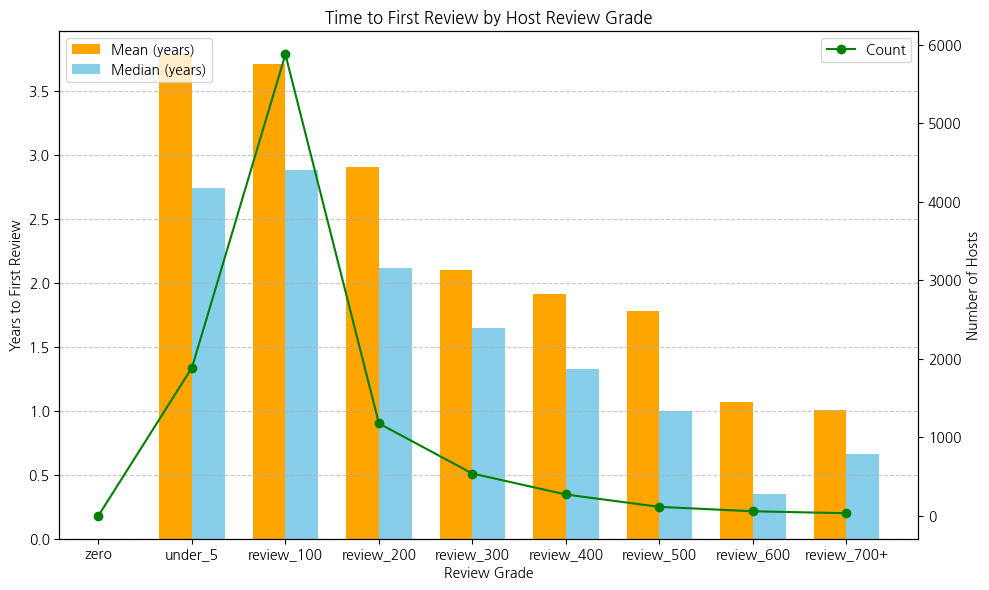

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
bar_width = 0.35
x = range(len(result))

# 1️⃣ 기본 막대차트 (평균/중앙값)
plt.bar([i - bar_width/2 for i in x], result["mean"],
        width=bar_width, label="Mean (years)", color="orange")
plt.bar([i + bar_width/2 for i in x], result["median"],
        width=bar_width, label="Median (years)", color="skyblue")

plt.xticks(x, result.index)
plt.xlabel("Review Grade")
plt.ylabel("Years to First Review")
plt.title("Time to First Review by Host Review Grade")
plt.legend(loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# 2️⃣ 보조 y축 추가해서 라인차트 그리기
ax1 = plt.gca()                # 현재 axis 가져오기
ax2 = ax1.twinx()              # 보조 y축 생성
counts = filtered.groupby("host_review_grade")["til_first_review_years"].count()
ax2.plot(x, counts, marker="o", color="green", label="Count")
ax2.set_ylabel("Number of Hosts")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()

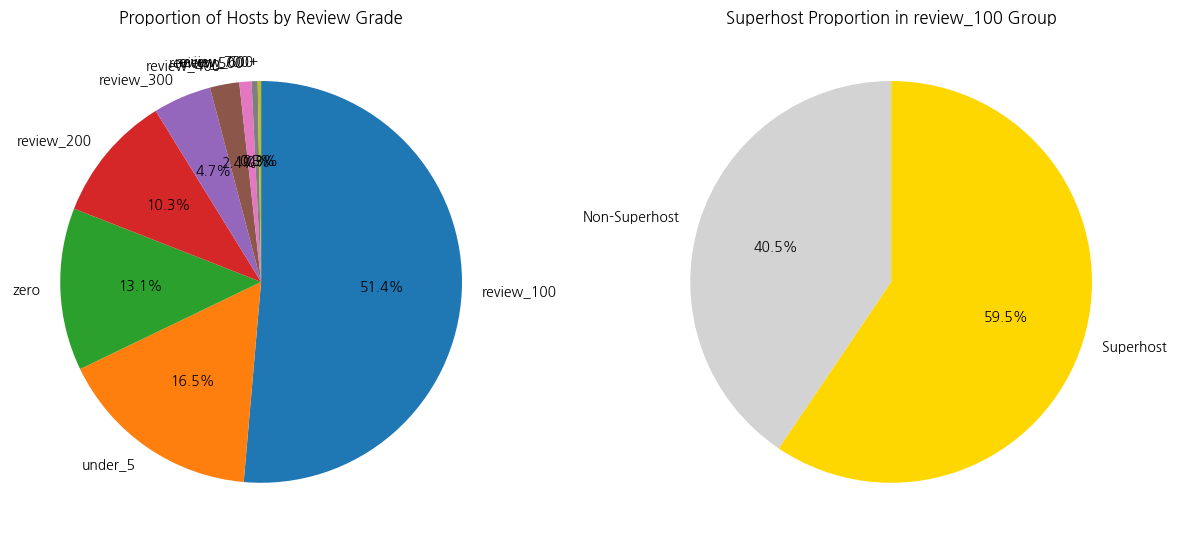

In [21]:
# 그룹별 호스트 수 계산
group_counts = df_clean["host_review_grade"].value_counts()

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.pie(group_counts,
        labels=group_counts.index,
        autopct="%.1f%%",
        startangle=90,
        counterclock=False)
plt.title("Proportion of Hosts by Review Grade")

# review_100 그룹 내 슈퍼호스트 비율
review100 = df_clean[df_clean["host_review_grade"] == "review_100"]
superhost_counts = review100["host_is_superhost"].value_counts()

plt.subplot(1,2,2)
plt.pie(superhost_counts,
        labels=["Superhost","Non-Superhost"],
        autopct="%.1f%%",
        colors=["gold","lightgrey"],
        startangle=90,
        counterclock=False)
plt.title("Superhost Proportion in review_100 Group")

plt.tight_layout()
plt.show()

In [16]:
#zero 그룹 외의 각 그룹별 통계 확인
filtered = df_clean[df_clean["host_review_grade"] != "zero"]

# 그룹별 til_first_review_days 분포 요약
reviewdays_pergroup = filtered.groupby("host_review_grade")["til_first_review_days"].describe()

reviewdays_pergroup

/tmp/ipython-input-3492800118.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reviewdays_pergroup = filtered.groupby("host_review_grade")["til_first_review_days"].describe()


,count,mean,std,min,25%,50%,75%,max
host_review_grade,,,,,,,,
zero,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
under_5,1886.0,1381.096501,1331.638576,-49.0,152.50,1001.0,2469.00,5481.0
review_100,5881.0,1356.693590,1263.228845,-1737.0,136.00,1055.0,2363.00,4979.0
review_200,1176.0,1061.791667,1022.391978,-707.0,131.00,772.5,1847.00,4281.0
review_300,537.0,767.869646,766.649656,-1941.0,87.00,602.0,1266.00,3238.0
review_400,270.0,699.103704,695.366478,-292.0,91.25,486.0,1070.25,2903.0
review_500,112.0,649.821429,689.169211,-219.0,38.75,364.5,1180.00,2461.0
review_600,56.0,390.839286,509.095268,-399.0,26.75,127.0,576.25,2232.0
review_700+,31.0,369.193548,456.816405,6.0,26.00,242.0,576.00,1698.0


In [18]:
#til_first_review_days 이 음수인 값들 확인
negatives = df_clean[df_clean["til_first_review_days"] < 0]

# 확인 -> 총 33개가 있음.
print(negatives[["host_since", "first_review", "til_first_review_days", "host_review_grade"]])

'''
under_5: 1개
review_100: 9개
review_200: 10개
review_300: 8개
review_400: 2개
review_500: 2개
review_600: 1개
'''

     host_since first_review  til_first_review_days host_review_grade
132  2013-10-10   2013-06-09                 -123.0        review_200
151  2015-11-03   2014-04-22                 -560.0        review_200
168  2013-10-10   2013-05-23                 -140.0        review_300
173  2013-10-10   2013-09-30                  -10.0        review_300
194  2018-09-05   2013-12-03                -1737.0        review_100
203  2015-06-29   2013-08-13                 -685.0        review_200
610  2017-08-28   2015-09-21                 -707.0        review_200
663  2018-03-28   2015-08-08                 -963.0        review_100
1170 2019-03-04   2016-08-13                 -933.0        review_300
1181 2017-04-11   2016-08-07                 -247.0        review_300
1358 2018-01-26   2016-12-23                 -399.0        review_600
1361 2019-03-04   2016-12-30                 -794.0        review_300
1387 2022-08-02   2017-04-09                -1941.0        review_300
1501 2018-06-07   20

In [27]:
#til_first_review_days 가 음수인 총 33개에 대하여 각 그룹별 '중앙값'으로 대치

# 1) 그룹별 중앙값(음수 제외하고 계산)
group_medians = (
    df_clean[df_clean["til_first_review_days"] >= 0]
    .groupby("host_review_grade")["til_first_review_days"]
    .median()
)

# 2) 음수값을 그룹별 중앙값으로 대치
def replace_with_group_median(row):
    if row["til_first_review_days"] < 0:
        return group_medians[row["host_review_grade"]]
    else:
        return row["til_first_review_days"]

df_clean["til_first_review_days"] = df_clean.apply(replace_with_group_median, axis=1)

# 3) til_first_review_years도 다시 업데이트
df_clean["til_first_review_years"] = df_clean["til_first_review_days"] / 365.25


/tmp/ipython-input-742504556.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("host_review_grade")["til_first_review_days"]


In [31]:
filtered = df_clean[df_clean["host_review_grade"] != "zero"]

reviewdays_pergroup_2 = (
    filtered.groupby("host_review_grade")["til_first_review_days"]
    .describe()
)

reviewdays_pergroup_2


#이것도 이것대로 이상해. 호스팅을 시작하고 이틀만에 리뷰를 받았다고??
#숙소를 올리고 고객을 받고 숙박 후 리뷰 쓰기까지의 텀이 있는데 어떻게 이틀만에 그게 가능하지?


/tmp/ipython-input-178224062.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filtered.groupby("host_review_grade")["til_first_review_days"]


,count,mean,std,min,25%,50%,75%,max
host_review_grade,,,,,,,,
zero,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
under_5,1886.0,1381.653234,1331.259800,2.0,154.00,1002.00,2469.00,5481.0
review_100,5881.0,1359.411835,1260.449751,2.0,138.00,1055.00,2363.00,4979.0
review_200,1176.0,1071.627551,1013.703198,2.0,151.75,773.25,1847.00,4281.0
review_300,537.0,785.802607,744.682715,2.0,98.00,602.00,1266.00,3238.0
review_400,270.0,704.211111,691.180562,5.0,102.25,486.00,1070.25,2903.0
review_500,112.0,660.160714,680.332567,4.0,46.25,366.75,1180.00,2461.0
review_600,56.0,400.232143,499.010184,5.0,27.00,127.50,576.25,2232.0
review_700+,31.0,369.193548,456.816405,6.0,26.00,242.00,576.00,1698.0


/tmp/ipython-input-588669226.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=groups_sorted, vert=False)


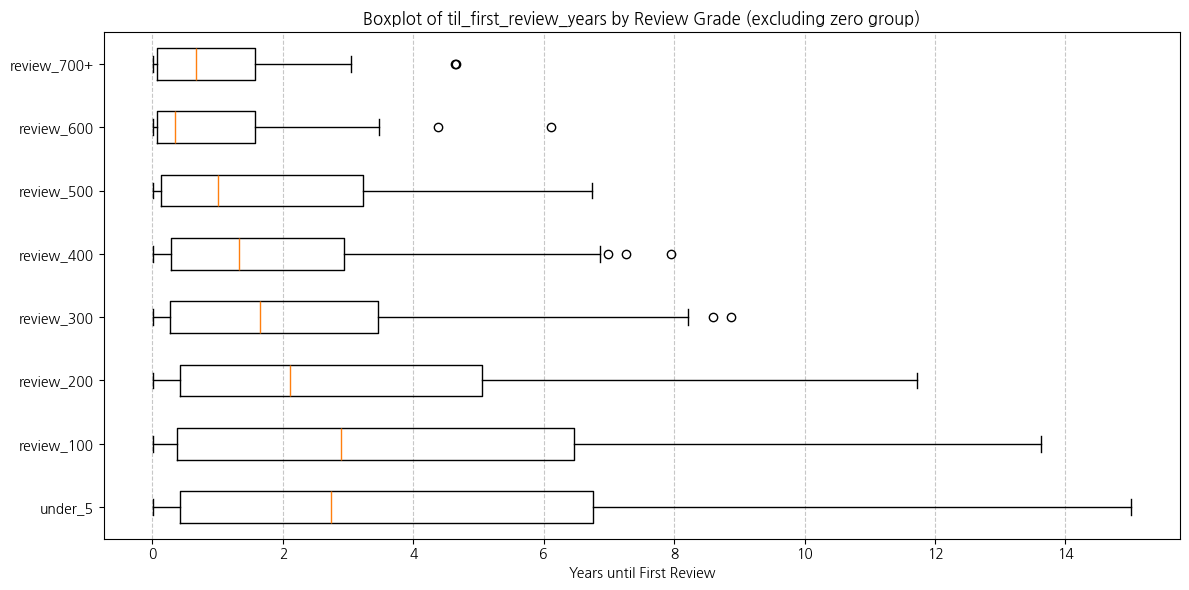

In [32]:
# zero 그룹 제외
filtered = df_clean[df_clean["host_review_grade"] != "zero"]

plt.figure(figsize=(12,6))

# 그룹 순서 정렬
groups_sorted = sorted(filtered["host_review_grade"].unique().tolist(),
                       key=lambda x: list(df_clean["host_review_grade"].cat.categories).index(x))

# 그룹별 데이터 준비
data = [filtered.loc[filtered["host_review_grade"] == g, "til_first_review_years"].dropna() for g in groups_sorted]

# 박스플롯 (연 단위 그대로)
plt.boxplot(data, labels=groups_sorted, vert=False)
plt.xlabel("Years until First Review")
plt.title("Boxplot of til_first_review_years by Review Grade (excluding zero group)")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

-------

In [ ]:
summary = (
    df_clean
    .groupby("host_review_grade")["number_of_reviews"]
    .agg(count="size", mean="mean", median="median")
    .reset_index()
)

summary

,host_review_grade,count,mean,median
0,review_100,5881,32.015474,24.0
1,review_200,1176,143.520408,141.0
2,review_300,537,242.759777,240.0
3,review_400,270,342.929630,339.5
4,review_500,112,441.321429,440.0
5,review_600,56,550.732143,557.0
6,review_700+,31,706.354839,662.0
7,under_5,1886,2.177625,2.0
8,zero,1497,0.000000,0.0


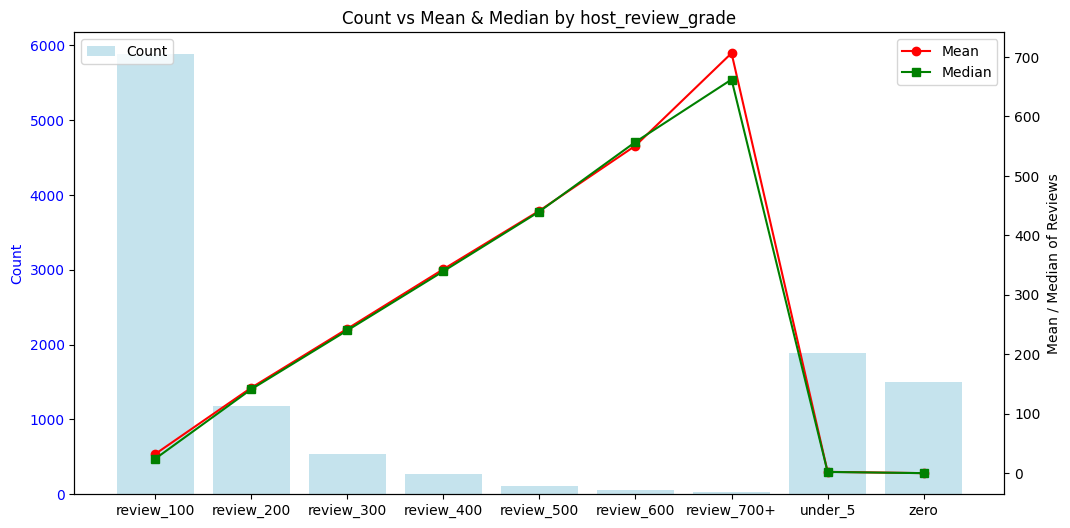

In [ ]:
import matplotlib.pyplot as plt

# 집계 테이블
summary = (
    df_clean
    .groupby("host_review_grade")["number_of_reviews"]
    .agg(count="size", mean="mean", median="median")
    .reset_index()
)

# 시각화
fig, ax1 = plt.subplots(figsize=(12,6))

# 1. count → bar chart (왼쪽 y축)
ax1.bar(summary["host_review_grade"], summary["count"], color="lightblue", alpha=0.7, label="Count")
ax1.set_ylabel("Count", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# 2. mean/median → line chart (오른쪽 y축)
ax2 = ax1.twinx()
ax2.plot(summary["host_review_grade"], summary["mean"], marker="o", color="red", label="Mean")
ax2.plot(summary["host_review_grade"], summary["median"], marker="s", color="green", label="Median")
ax2.set_ylabel("Mean / Median of Reviews", color="black")
ax2.tick_params(axis="y", labelcolor="black")

# 타이틀 & 범례
plt.title("Count vs Mean & Median by host_review_grade")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()


In [ ]:
# host_review_grade 카테고리 순서 지정
grade_order = ["zero","under_5","review_100","review_200","review_300",
               "review_400","review_500","review_600","review_700+"]
df_clean["host_review_grade"] = pd.Categorical(
    df_clean["host_review_grade"], categories=grade_order, ordered=True
)

# 음수 값은 NaN 처리
df_clean.loc[df_clean["til_first_review_years"] < 0, "til_first_review_years"] = np.nan

# 요약 함수
def grade_summary(df, value_col):
    grp = df.groupby("host_review_grade")[value_col]
    out = grp.agg(
        total_rows = "size",
        valid_rows = "count",
        mean = "mean",
        median = "median",
        std = "std",
        min = "min",
        q1 = lambda s: s.quantile(0.25),
        q3 = lambda s: s.quantile(0.75),
        max = "max"
    ).reset_index()
    out["missing_rows"] = out["total_rows"] - out["valid_rows"]
    out["missing_rate"] = (out["missing_rows"] / out["total_rows"]).round(3)
    return out

# til_first_review_years에 대한 요약
til_first_years_summary = grade_summary(df_clean, "til_first_review_years")
til_first_years_summary

/tmp/ipython-input-632305291.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby("host_review_grade")[value_col]


,host_review_grade,total_rows,valid_rows,mean,median,std,min,q1,q3,max,missing_rows,missing_rate
0,zero,1497,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1497,1.000
1,under_5,1886,1885,3.783313,2.746064,3.645679,0.005476,0.421629,6.762491,15.006160,1,0.001
2,review_100,5881,5872,3.723144,2.891170,3.453413,0.005476,0.377823,6.479124,13.631759,9,0.002
3,review_200,1176,1166,2.940980,2.197125,2.786212,0.005476,0.401095,5.084873,11.720739,10,0.009
4,review_300,537,529,2.159020,1.691992,2.053270,0.005476,0.268309,3.559206,8.865161,8,0.015
5,review_400,270,268,1.932483,1.352498,1.898714,0.013689,0.268309,2.938398,7.947981,2,0.007
6,review_500,112,110,1.822139,1.044490,1.876401,0.010951,0.122519,3.258042,6.737851,2,0.018
7,review_600,56,55,1.109377,0.350445,1.374976,0.013689,0.073922,1.709788,6.110883,1,0.018
8,review_700+,31,31,1.010797,0.662560,1.250695,0.016427,0.071184,1.577002,4.648871,0,0.000


In [ ]:
#호스팅 시작 이후 첫 리뷰 받기까지의 기간(years 기준)
filtered = df_clean[df_clean["host_review_grade"] != "zero"]["til_first_review_years"].dropna()

mean_val = filtered.mean()
median_val = filtered.median()

print("평균 (years):", mean_val)
print("중앙값 (years):", median_val)

평균 (years): 3.4667047138468265
중앙값 (years): 2.4435318275154003


/tmp/ipython-input-1765832933.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipython-input-1765832933.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(
/tmp/ipython-input-1765832933.py:21: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(


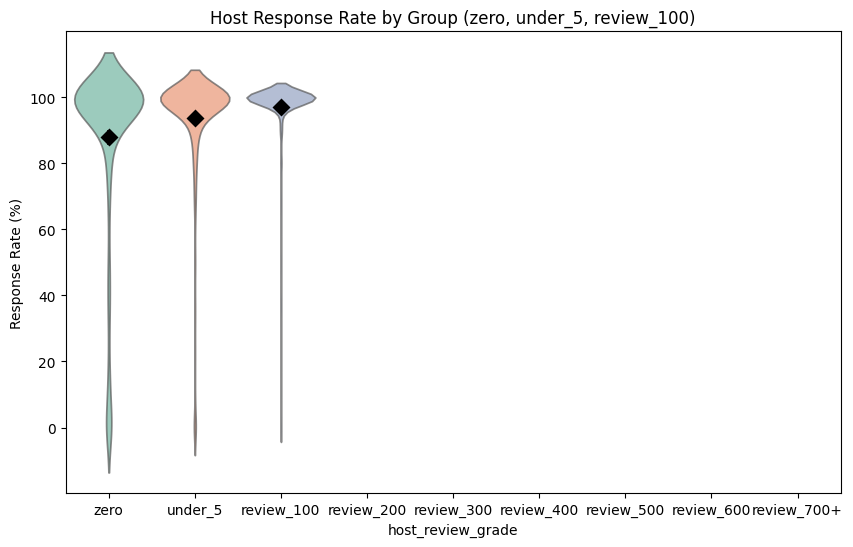

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt

# 세 그룹만 필터링
subset3 = df_clean[df_clean["host_review_grade"].isin(["zero", "under_5", "review_100"])]

plt.figure(figsize=(10,6))

# 1) 분포: 바이올린 플롯
sns.violinplot(
    x="host_review_grade",
    y="host_response_rate",
    data=subset3,
    inner=None, palette="Set2", alpha=0.7
)

# 2) 평균값 표시: pointplot
sns.pointplot(
    x="host_review_grade",
    y="host_response_rate",
    data=subset3,
    ci=95, color="black", join=False, markers="D"
)

plt.title("Host Response Rate by Group (zero, under_5, review_100)")
plt.ylabel("Response Rate (%)")
plt.xlabel("host_review_grade")
plt.show()

#시각화

###리뷰 수가 0이 아닌 숙소 중 리뷰 개수((number_of_reviews)) vs

응답률(host_response_rate) / 응답속도(host_response_time) / 수락률(host_acceptance_rate)

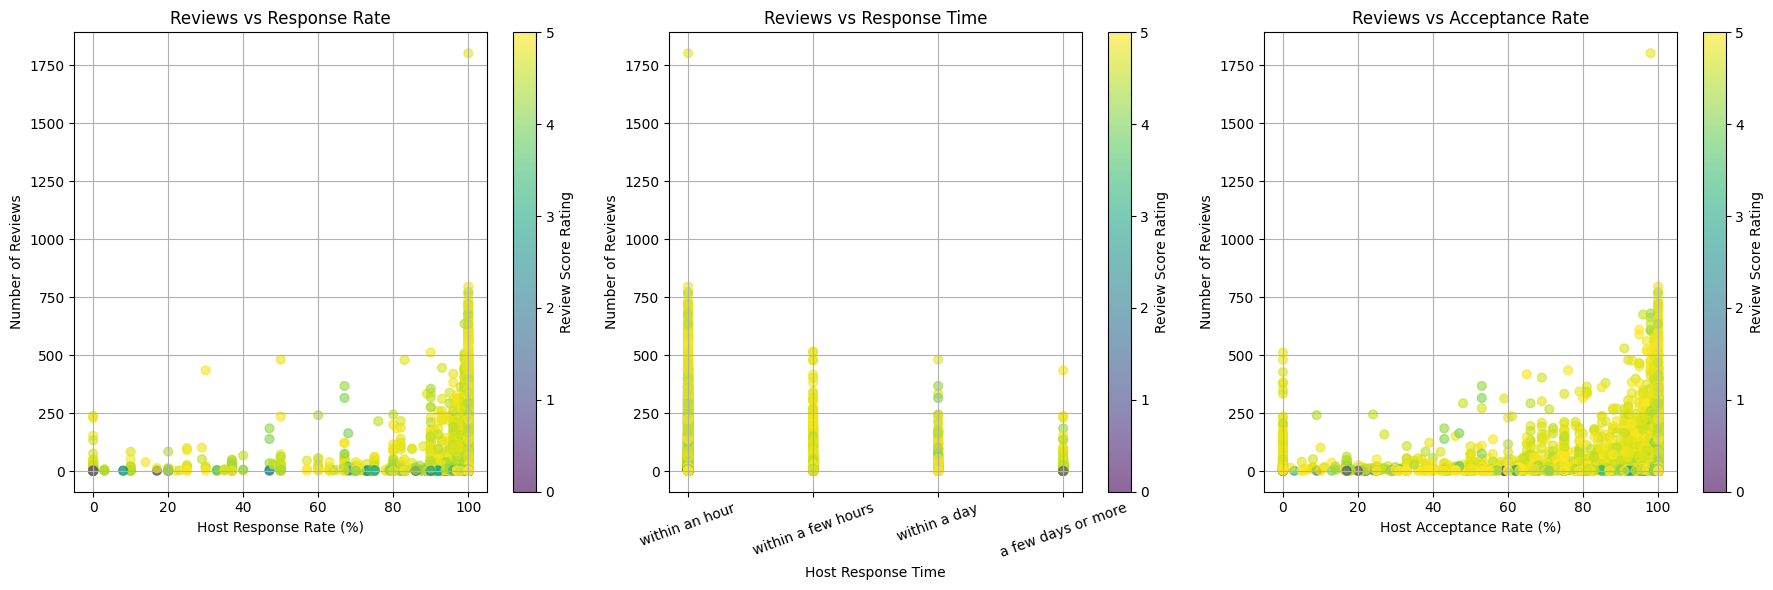

In [ ]:
import matplotlib.pyplot as plt

# 응답속도 → 숫자 매핑
response_order = {
    'within an hour': 1,
    'within a few hours': 2,
    'within a day': 3,
    'a few days or more': 4
}
response_time_num = df_clean.loc[df_clean['has_review'], 'host_response_time'].map(response_order)

# 리뷰 있는 데이터 필터
mask = df_clean['has_review']

plt.figure(figsize=(18,6))

# (a) 응답률 vs 리뷰수
plt.subplot(1,3,1)
sc0 = plt.scatter(
    df_clean.loc[mask, 'host_response_rate'],
    df_clean.loc[mask, 'number_of_reviews'],
    c=df_clean.loc[mask, 'review_scores_rating'],
    cmap='viridis',
    alpha=0.6,
    s=40
)
plt.colorbar(sc0, label='Review Score Rating')
plt.xlabel('Host Response Rate (%)')
plt.ylabel('Number of Reviews')
plt.title('Reviews vs Response Rate')
plt.grid(True)

# (b) 응답속도 vs 리뷰수
plt.subplot(1,3,2)
sc1 = plt.scatter(
    response_time_num,
    df_clean.loc[mask, 'number_of_reviews'],
    c=df_clean.loc[mask, 'review_scores_rating'],
    cmap='viridis',
    alpha=0.6,
    s=40
)
plt.colorbar(sc1, label='Review Score Rating')
plt.xticks(list(response_order.values()), list(response_order.keys()), rotation=20)
plt.xlabel('Host Response Time')
plt.ylabel('Number of Reviews')
plt.title('Reviews vs Response Time')
plt.grid(True)

# (c) 수락률 vs 리뷰수
plt.subplot(1,3,3)
sc2 = plt.scatter(
    df_clean.loc[mask, 'host_acceptance_rate'],
    df_clean.loc[mask, 'number_of_reviews'],
    c=df_clean.loc[mask, 'review_scores_rating'],
    cmap='viridis',
    alpha=0.6,
    s=40
)
plt.colorbar(sc2, label='Review Score Rating')
plt.xlabel('Host Acceptance Rate (%)')
plt.ylabel('Number of Reviews')
plt.title('Reviews vs Acceptance Rate')
plt.grid(True)

plt.tight_layout()
plt.show()

###

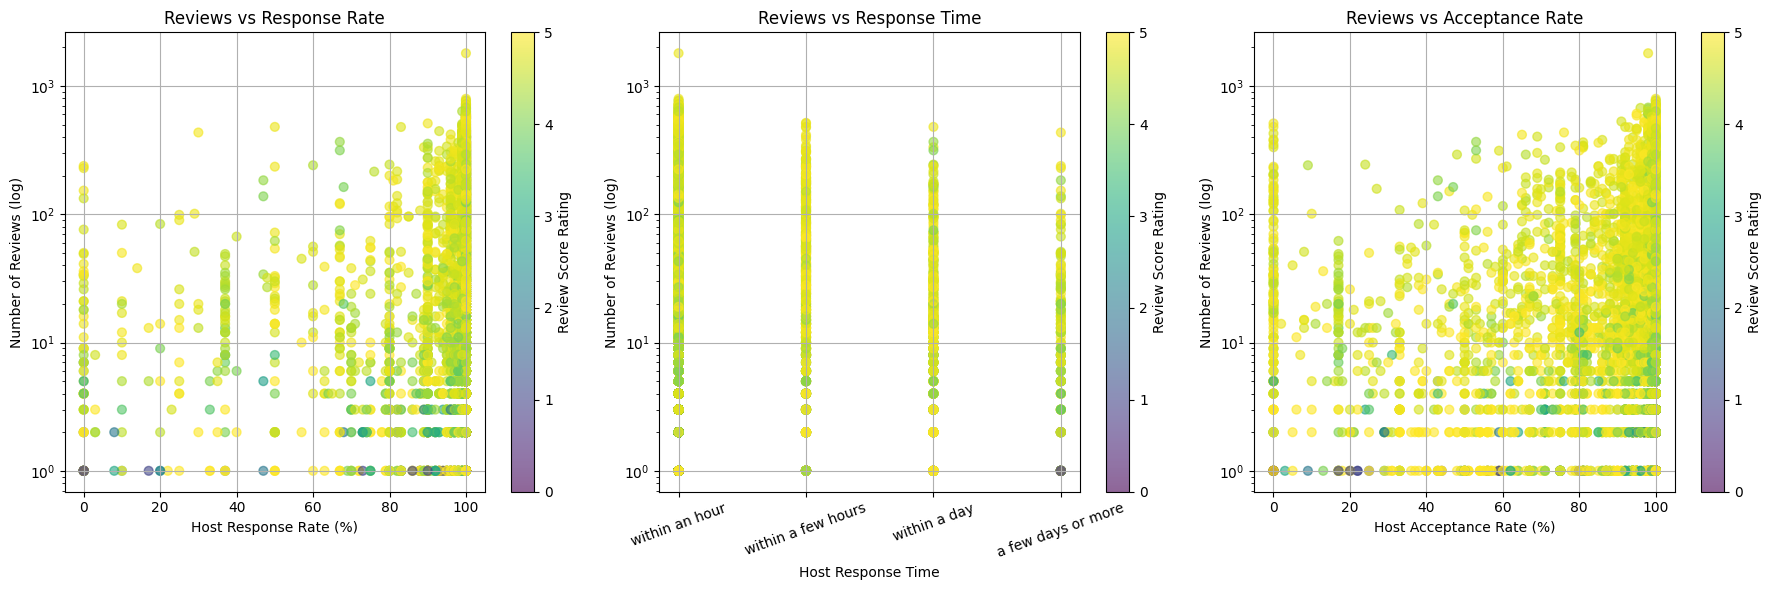

In [ ]:
import matplotlib.pyplot as plt

# 응답속도 → 숫자 매핑
response_order = {
    'within an hour': 1,
    'within a few hours': 2,
    'within a day': 3,
    'a few days or more': 4
}
response_time_num = df_clean.loc[df_clean['has_review'], 'host_response_time'].map(response_order)

# 리뷰 있는 데이터 필터
mask = df_clean['has_review']

fig, axes = plt.subplots(1, 3, figsize=(18,6))

# (a) 응답률 vs 리뷰수
sc0 = axes[0].scatter(
    df_clean.loc[mask, 'host_response_rate'],
    df_clean.loc[mask, 'number_of_reviews'],
    c=df_clean.loc[mask, 'review_scores_rating'],
    cmap='viridis',
    alpha=0.6,
    s=40
)
axes[0].set_yscale('log')
axes[0].set_xlabel('Host Response Rate (%)')
axes[0].set_ylabel('Number of Reviews (log)')
axes[0].set_title('Reviews vs Response Rate')
axes[0].grid(True)
fig.colorbar(sc0, ax=axes[0], label='Review Score Rating')

# (b) 응답속도 vs 리뷰수
sc1 = axes[1].scatter(
    response_time_num,
    df_clean.loc[mask, 'number_of_reviews'],
    c=df_clean.loc[mask, 'review_scores_rating'],
    cmap='viridis',
    alpha=0.6,
    s=40
)
axes[1].set_yscale('log')
axes[1].set_xticks(list(response_order.values()))
axes[1].set_xticklabels(list(response_order.keys()), rotation=20)
axes[1].set_xlabel('Host Response Time')
axes[1].set_ylabel('Number of Reviews (log)')
axes[1].set_title('Reviews vs Response Time')
axes[1].grid(True)
fig.colorbar(sc1, ax=axes[1], label='Review Score Rating')

# (c) 수락률 vs 리뷰수
sc2 = axes[2].scatter(
    df_clean.loc[mask, 'host_acceptance_rate'],
    df_clean.loc[mask, 'number_of_reviews'],
    c=df_clean.loc[mask, 'review_scores_rating'],
    cmap='viridis',
    alpha=0.6,
    s=40
)
axes[2].set_yscale('log')
axes[2].set_xlabel('Host Acceptance Rate (%)')
axes[2].set_ylabel('Number of Reviews (log)')
axes[2].set_title('Reviews vs Acceptance Rate')
axes[2].grid(True)
fig.colorbar(sc2, ax=axes[2], label='Review Score Rating')

plt.tight_layout()
plt.show()


#아래는 무시

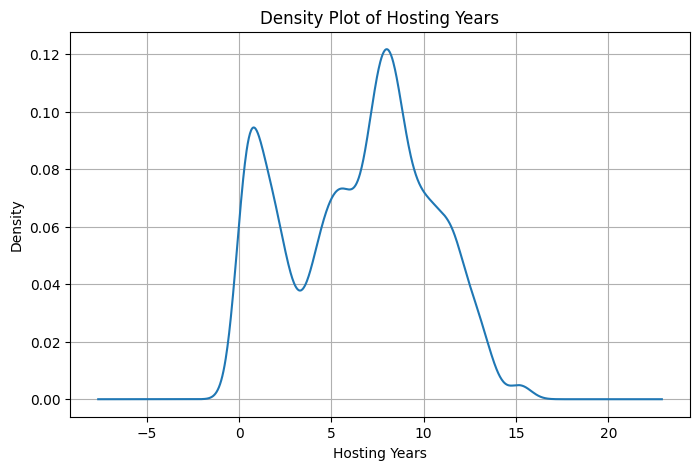

In [ ]:
import matplotlib.pyplot as plt
df['hosting_years'].dropna().plot(kind='kde', figsize=(8,5))
plt.title('Density Plot of Hosting Years')
plt.xlabel('Hosting Years')
plt.grid(True)
plt.show()

In [ ]:
df['first_review'] = pd.to_datetime(df['first_review'])
df['last_review'] = pd.to_datetime(df['last_review'])
df['til_first_review_days'] = (df['first_review']-df['host_since']).dt.days
df['til_first_review_years'] = df['til_first_review_days'] / 365.25

df['til_first_review_days'].describe()

,til_first_review_days
count,9949.000000
mean,1260.362448
std,1224.851076
min,-1941.000000
25%,131.000000
50%,884.000000
75%,2231.000000
max,5481.000000


In [ ]:
df['has_availability'].isnull().sum()

np.int64(524)

In [ ]:
df['id'].duplicated().sum()

np.int64(0)

In [ ]:
df['id'].isnull().sum()

np.int64(0)

In [ ]:
df['has_review'] = df['number_of_reviews'] > 0
print(df['has_review'].value_counts())

has_review
True     9949
False    1497
Name: count, dtype: int64


In [ ]:
#평균 평점이 4.9 이상인 숙소 vs 미만인 숙소 비율

# null 값 제외
ratings = df['review_scores_rating'].dropna()

# 조건 나누기
above_49 = (ratings >= 4.9).sum()
below_49 = (ratings < 4.9).sum()

# 비율 계산
total = len(ratings)
above_ratio = above_49 / total * 100
below_ratio = below_49 / total * 100

print(f"4.9 이상 숙소 비율: {above_ratio:.2f}%")
print(f"4.9 미만 숙소 비율: {below_ratio:.2f}%")

4.9 이상 숙소 비율: 32.20%
4.9 미만 숙소 비율: 67.80%


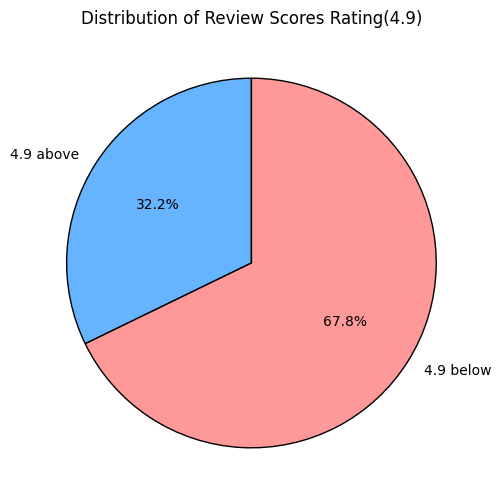

In [ ]:
import matplotlib.pyplot as plt


#파이차트
labels = ['4.9 above', '4.9 below']
sizes = [above_49, below_49]
colors = ['#66b3ff', '#ff9999']

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%.1f%%', startangle=90, colors=colors, wedgeprops={'edgecolor':'black'})
plt.title('Distribution of Review Scores Rating(4.9)')
plt.show()

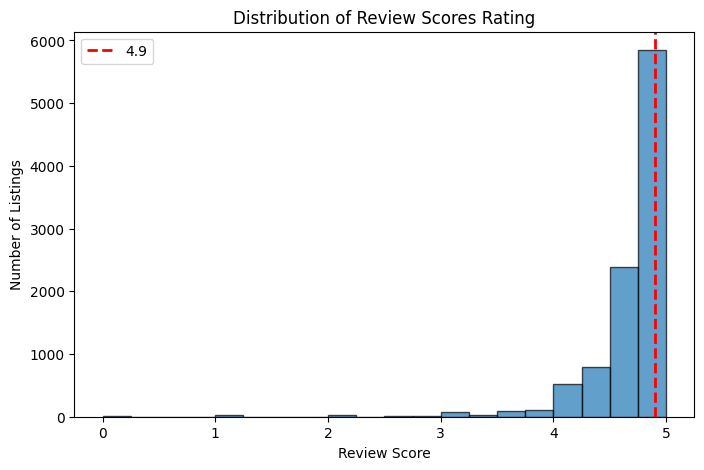

In [ ]:
import matplotlib.pyplot as plt

# 히스토그램
plt.figure(figsize=(8,5))
plt.hist(ratings, bins=20, edgecolor='black', alpha=0.7)
plt.axvline(4.9, color='red', linestyle='--', linewidth=2, label='4.9')
plt.title('Distribution of Review Scores Rating')
plt.xlabel('Review Score')
plt.ylabel('Number of Listings')
plt.legend()
plt.show()

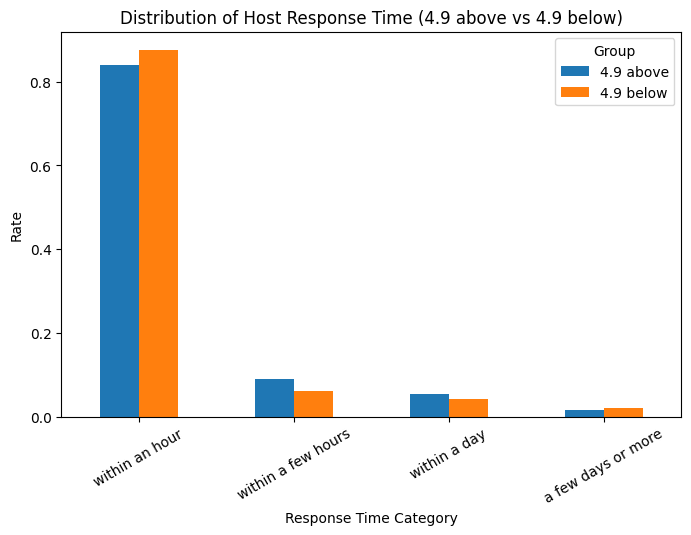

In [ ]:
#host_response_time 분포

# 평점 기준으로 그룹 나누기 (NaN은 False 처리됨)
above_mask = df['review_scores_rating'] >= 4.9
below_mask = df['review_scores_rating'] < 4.9

# 그룹별 host_response_time 분포 계산
above_response = df.loc[above_mask, 'host_response_time'].value_counts(normalize=True)
below_response = df.loc[below_mask, 'host_response_time'].value_counts(normalize=True)

# 데이터프레임으로 합치기
response_df = pd.DataFrame({
    '4.9 above': above_response,
    '4.9 below': below_response
}).fillna(0)

# 막대그래프 그리기
response_df.plot(kind='bar', figsize=(8,5))
plt.title('Distribution of Host Response Time (4.9 above vs 4.9 below)')
plt.ylabel('Rate')
plt.xlabel('Response Time Category')
plt.xticks(rotation=30)
plt.legend(title='Group')
plt.show()

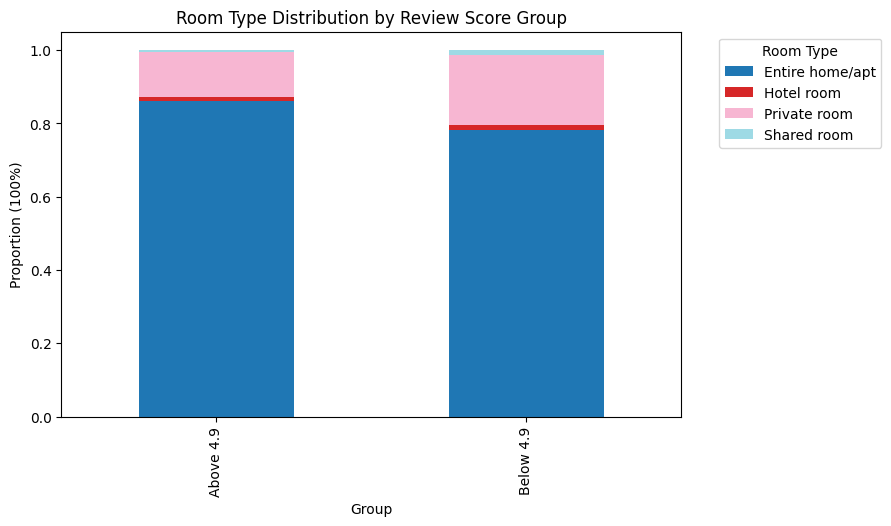

In [ ]:
#각 그룹별로 방 타입이 어떻게되는지 100% 스택 막대
# Room type distribution (ratio) for each group
above_room = df.loc[above_mask, 'room_type'].value_counts(normalize=True)
below_room = df.loc[below_mask, 'room_type'].value_counts(normalize=True)

# Combine into one DataFrame
room_df = pd.DataFrame({
    'Above 4.9': above_room,
    'Below 4.9': below_room
}).fillna(0).T   # transpose: groups as rows, room_type as columns

# 100% stacked bar chart
room_df.plot(kind='bar', stacked=True, figsize=(8,5), colormap='tab20')
plt.title('Room Type Distribution by Review Score Group')
plt.ylabel('Proportion (100%)')
plt.xlabel('Group')
plt.legend(title='Room Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
#평점이 존재하면서 리뷰 개수 5개 기준으로 비율 계산

# ratings에서 가져온 인덱스로 필터링
valid_idx = ratings.index
reviews_filtered = df.loc[valid_idx, 'number_of_reviews'].dropna()

# 조건별 개수
less_than_5 = (reviews_filtered < 5).sum()
five_or_more = (reviews_filtered >= 5).sum()

# 전체
total = len(reviews_filtered)

# 비율
less_ratio = less_than_5 / total * 100
five_ratio = five_or_more / total * 100

print(f"Reviews < 5: {less_ratio:.2f}%")
print(f"Reviews >= 5: {five_ratio:.2f}%")

Reviews < 5: 18.97%
Reviews >= 5: 81.03%


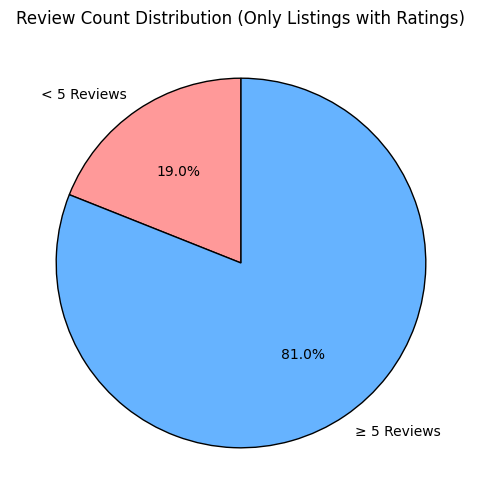

In [ ]:
labels = ['< 5 Reviews', '≥ 5 Reviews']
sizes = [less_than_5, five_or_more]
colors = ['#ff9999', '#66b3ff']

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%.1f%%', startangle=90,
        colors=colors, wedgeprops={'edgecolor':'black'})
plt.title('Review Count Distribution (Only Listings with Ratings)')
plt.show()

In [ ]:
#평점이 있지만 그 중에서 평점이 5개 미만/이상인 그룹의 평점 평균

# 그룹 나누기
less_mask = reviews_filtered < 5
more_mask = reviews_filtered >= 5

# 그룹별 평점 평균
less_mean = ratings.loc[less_mask].mean()
more_mean = ratings.loc[more_mask].mean()

print(f"Average rating (< 5 reviews): {less_mean:.2f}")
print(f"Average rating (≥ 5 reviews): {more_mean:.2f}")

Average rating (< 5 reviews): 4.51
Average rating (≥ 5 reviews): 4.72


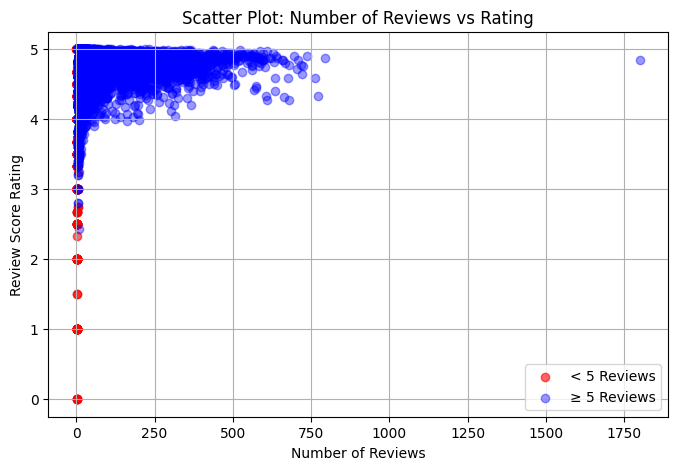

In [ ]:
#리뷰 5개미만, 이상 그룹별 평점 산포도

plt.figure(figsize=(8,5))

# < 5 reviews
plt.scatter(reviews_filtered[less_mask], ratings[less_mask],
            alpha=0.6, color='red', label='< 5 Reviews')

# ≥ 5 reviews
plt.scatter(reviews_filtered[more_mask], ratings[more_mask],
            alpha=0.4, color='blue', label='≥ 5 Reviews')

plt.title('Scatter Plot: Number of Reviews vs Rating')
plt.xlabel('Number of Reviews')
plt.ylabel('Review Score Rating')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
less_count = less_mask.sum()
more_count = more_mask.sum()

print(f"Number of listings with < 5 reviews: {less_count}")
print(f"Number of listings with ≥ 5 reviews: {more_count}")

Number of listings with < 5 reviews: 1888
Number of listings with ≥ 5 reviews: 8063


In [ ]:
df['number_of_reviews'].describe()

,number_of_reviews
count,11446.000000
mean,59.958850
std,99.617144
min,0.000000
25%,3.000000
50%,18.000000
75%,70.000000
max,1801.000000


In [ ]:
zero_reviews = (df['number_of_reviews'] == 0).sum()
zero_reviews

np.int64(1497)

In [ ]:
ratings.sum()

np.float64(46590.97)

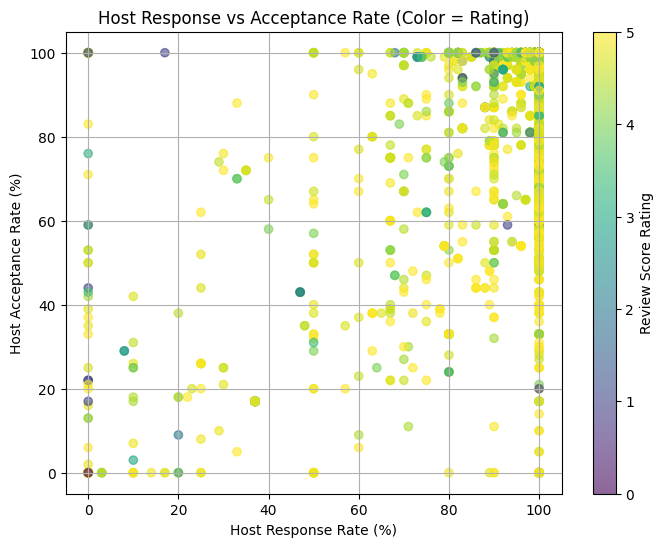

In [ ]:
import matplotlib.pyplot as plt

# 조건 필터링
mask = (df['number_of_reviews'] > 0) & (df['review_scores_rating'].notna())
df_valid = df.loc[mask].copy()

# 문자(%) → 숫자 변환
df_valid['host_response_rate'] = df_valid['host_response_rate'].replace('%','', regex=True).astype(float)
df_valid['host_acceptance_rate'] = df_valid['host_acceptance_rate'].replace('%','', regex=True).astype(float)

# 산점도 with 색 = 평점
plt.figure(figsize=(8,6))
sc = plt.scatter(
    df_valid['host_response_rate'],
    df_valid['host_acceptance_rate'],
    c=df_valid['review_scores_rating'],
    cmap='viridis',
    alpha=0.6
)

plt.colorbar(sc, label='Review Score Rating')
plt.title('Host Response vs Acceptance Rate (Color = Rating)')
plt.xlabel('Host Response Rate (%)')
plt.ylabel('Host Acceptance Rate (%)')
plt.grid(True)
plt.show()


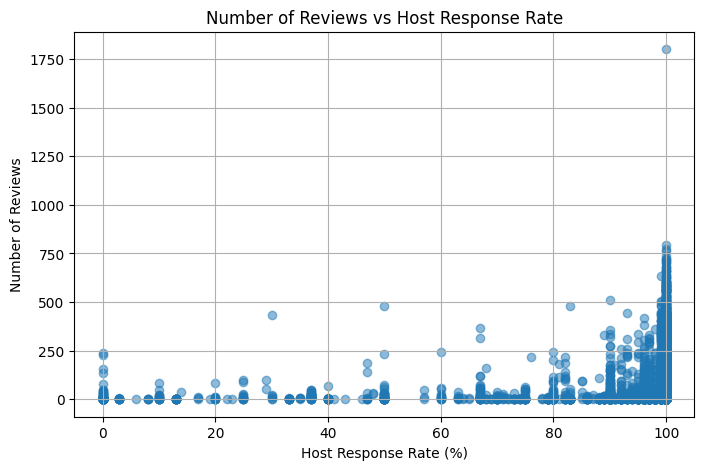

In [ ]:
#y: 리뷰 개수 x: 호스트 응답률

# 응답률(%) → 숫자형 변환
df['host_response_rate'] = df['host_response_rate'].replace('%','', regex=True).astype(float)

plt.figure(figsize=(8,5))
plt.scatter(df['host_response_rate'], df['number_of_reviews'], alpha=0.5)
plt.title('Number of Reviews vs Host Response Rate')
plt.xlabel('Host Response Rate (%)')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.show()

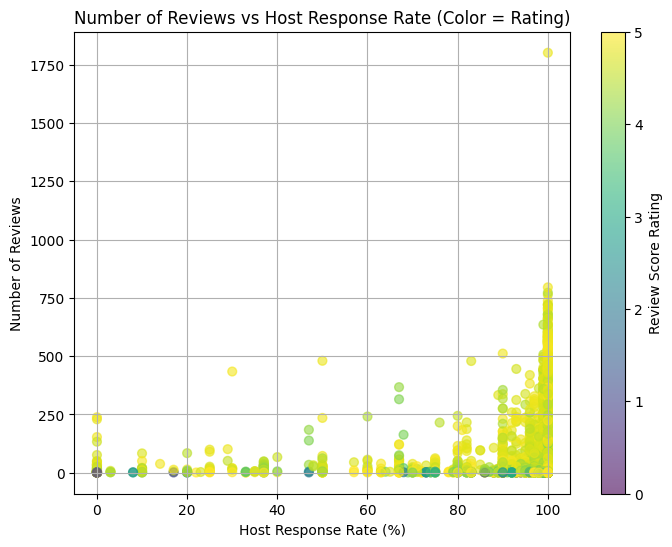

In [ ]:
#y: 리뷰 개수 x: 호스트 응답률, 별점에 따라 색상 구분 (버블차트)
# 응답률(%) → 숫자형 변환
df['host_response_rate'] = df['host_response_rate'].replace('%','', regex=True).astype(float)

plt.figure(figsize=(8,6))
sc = plt.scatter(
    df['host_response_rate'],
    df['number_of_reviews'],
    c=df['review_scores_rating'],   # 색상: 평점
    cmap='viridis',                 # 색상 팔레트
    alpha=0.6,
    s=40                            # 점 크기 (bubble size)
)

plt.colorbar(sc, label='Review Score Rating')
plt.title('Number of Reviews vs Host Response Rate (Color = Rating)')
plt.xlabel('Host Response Rate (%)')
plt.ylabel('Number of Reviews')
plt.grid(True)

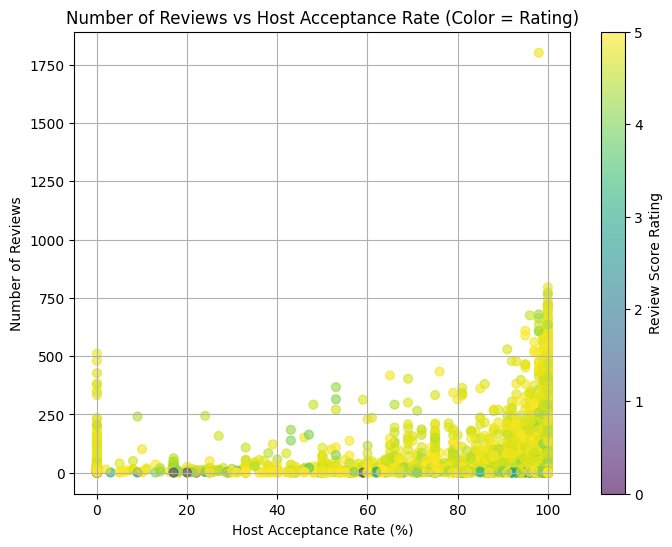

In [ ]:
#y: 리뷰 개수 x: 호스트 수락률, 별점에 따라 색상 구분 (버블차트)

# 수락률(%) → 숫자형 변환
df['host_acceptance_rate'] = df['host_acceptance_rate'].replace('%','', regex=True).astype(float)

plt.figure(figsize=(8,6))
sc = plt.scatter(
    df['host_acceptance_rate'],
    df['number_of_reviews'],
    c=df['review_scores_rating'],   # 색상: 평점
    cmap='viridis',
    alpha=0.6,
    s=40
)

plt.colorbar(sc, label='Review Score Rating')
plt.title('Number of Reviews vs Host Acceptance Rate (Color = Rating)')
plt.xlabel('Host Acceptance Rate (%)')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.show()

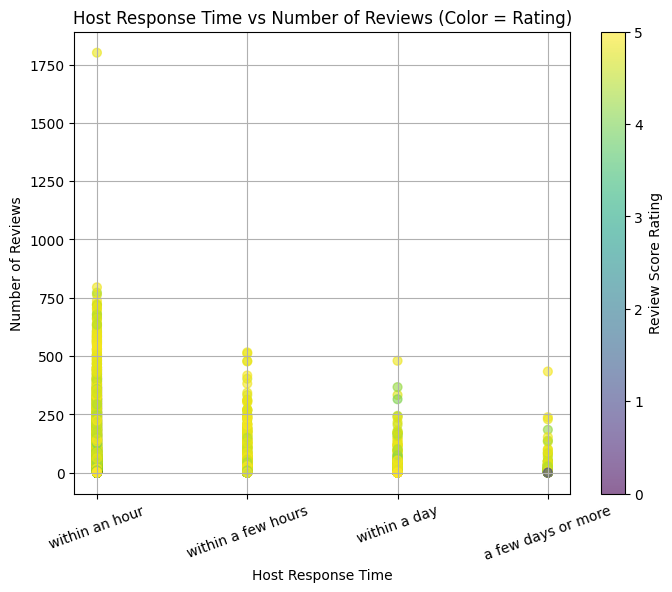

In [ ]:
#y: 리뷰 개수 x: 호스트 응답 시간, 별점에 따라 색상 구분
# 응답 속도 순서 정의
response_order = {
    'within an hour': 1,
    'within a few hours': 2,
    'within a day': 3,
    'a few days or more': 4
}

# 매핑해서 숫자형으로 변환
df['response_time_num'] = df['host_response_time'].map(response_order)

plt.figure(figsize=(8,6))
sc = plt.scatter(
    df['response_time_num'],
    df['number_of_reviews'],
    c=df['review_scores_rating'],   # 색상 = 평점
    cmap='viridis',
    alpha=0.6,
    s=40
)

# 컬러바
plt.colorbar(sc, label='Review Score Rating')

# x축 레이블을 다시 카테고리로 교체
plt.xticks(list(response_order.values()), list(response_order.keys()), rotation=20)

plt.title('Host Response Time vs Number of Reviews (Color = Rating)')
plt.xlabel('Host Response Time')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.show()

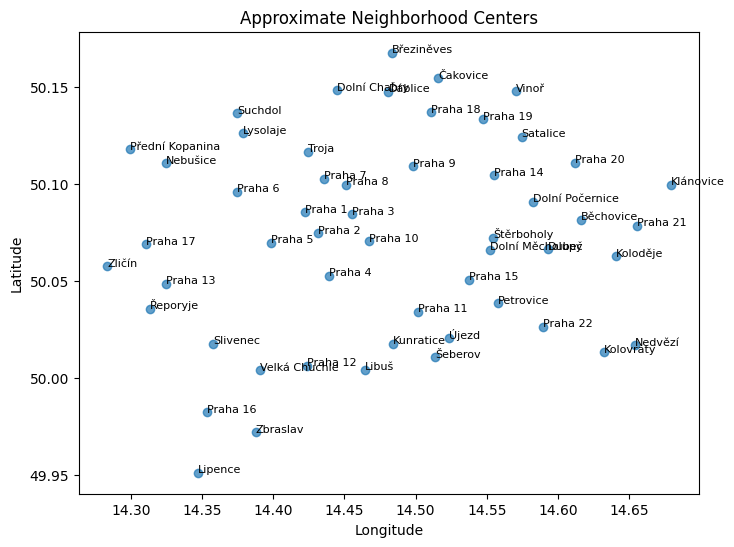

In [ ]:
# 지역 시각화

# 유효한 위도/경도만
df_valid_geo = df[['neighbourhood_cleansed', 'latitude', 'longitude']].dropna()

# 동네별 평균 좌표 계산. 각 neighbourhood_cleansed 별로 평균 위도/경도를 구하면, 그 지역의 대략적인 중심 좌표가 됨
geo_centers = df_valid_geo.groupby('neighbourhood_cleansed')[['latitude','longitude']].mean()

# 복사본 생성
df_cleans_geo = df.copy()

# 결측치 채우기 (복사본 기준으로)
df_cleans_geo['latitude'] = df_cleans_geo['latitude'].fillna(df_cleans_geo['neighbourhood_cleansed'].map(geo_centers['latitude']))
df_cleans_geo['longitude'] = df_cleans_geo['longitude'].fillna(df_cleans_geo['neighbourhood_cleansed'].map(geo_centers['longitude']))

# 시각화
plt.figure(figsize=(8,6))
plt.scatter(geo_centers['longitude'], geo_centers['latitude'], alpha=0.7)
for name, (lat, lon) in geo_centers.iterrows():
    plt.text(lon, lat, name, fontsize=8)
plt.title("Approximate Neighborhood Centers")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

<>:10: SyntaxWarning: invalid escape sequence '\$'
<>:10: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipython-input-922155371.py:10: SyntaxWarning: invalid escape sequence '\$'
  tmp['price'] = pd.to_numeric(tmp['price'].replace('[\$,]', '', regex=True), errors='coerce')


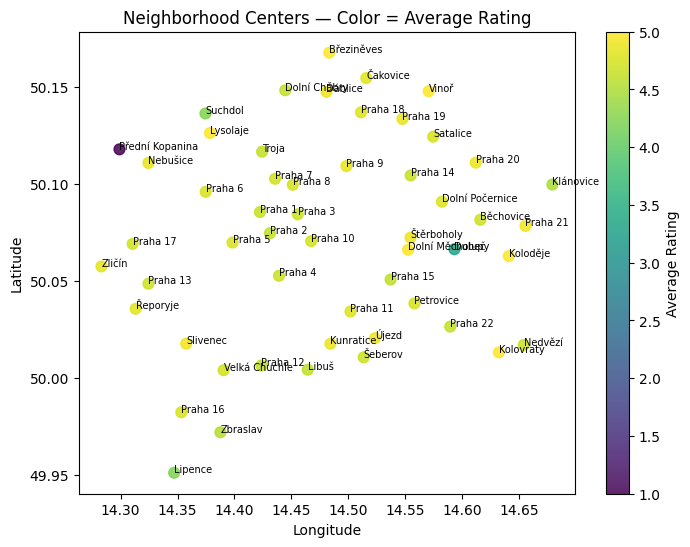

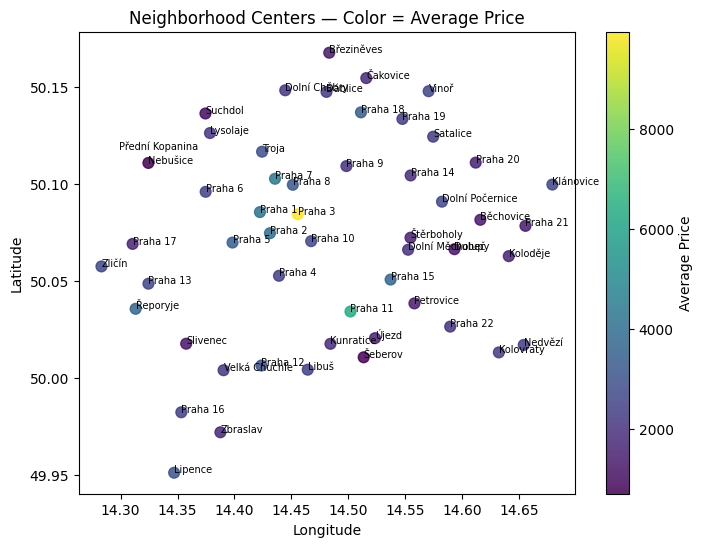

In [ ]:
#각 도시의 평점을 색상으로 나타내는 차트 하나, 가격을 색상으로 나타내는 차트


# --- Prep ---
# If df_cleans_geo doesn't exist yet, fall back to df
base = df_cleans_geo if 'df_cleans_geo' in globals() else df.copy()

# Price → numeric
tmp = base[['neighbourhood_cleansed','latitude','longitude','review_scores_rating','price']].copy()
tmp['price'] = pd.to_numeric(tmp['price'].replace('[\$,]', '', regex=True), errors='coerce')

# Drop rows without coords (centers need lat/lon)
tmp = tmp.dropna(subset=['latitude','longitude'])

# Neighborhood-level centers + metrics
agg = tmp.groupby('neighbourhood_cleansed', as_index=False).agg(
    latitude=('latitude','mean'),
    longitude=('longitude','mean'),
    avg_rating=('review_scores_rating','mean'),
    avg_price=('price','mean')
).dropna(subset=['latitude','longitude'])

# --- Chart 1: color by average rating ---
plt.figure(figsize=(8,6))
sc1 = plt.scatter(
    agg['longitude'],
    agg['latitude'],
    c=agg['avg_rating'],
    s=60,
    alpha=0.85
)
plt.colorbar(sc1, label='Average Rating')
plt.title('Neighborhood Centers — Color = Average Rating')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# optional tiny labels (comment out if cluttered)
for _, r in agg.iterrows():
    plt.text(r['longitude'], r['latitude'], str(r['neighbourhood_cleansed']), fontsize=7)

plt.show()

# --- Chart 2: color by average price ---
plt.figure(figsize=(8,6))
sc2 = plt.scatter(
    agg['longitude'],
    agg['latitude'],
    c=agg['avg_price'],
    s=60,
    alpha=0.85
)
plt.colorbar(sc2, label='Average Price')
plt.title('Neighborhood Centers — Color = Average Price')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# optional tiny labels
for _, r in agg.iterrows():
    plt.text(r['longitude'], r['latitude'], str(r['neighbourhood_cleansed']), fontsize=7)

plt.show()

In [ ]:
df_cleans_geo.to_csv("df_cleans_geo.csv", index=False, encoding="utf-8-sig")

In [ ]:
df['last_scraped'].unique()

array(['2024-03-25', '2024-03-26', '2023-12-20', '2023-06-24',
       '2023-09-17'], dtype=object)